In [1]:
'''
NON linear BVP:
     - div( mu(u) * grad(u) ) = f  in domain
                                          u = g  on bdry dirichlet
                         - mu(u) nabla(u).n = c (u^q -u_ref^q) on the 'radiative' bdry
                         - mu(u) nabla(u).n = 0 elsewhere

The diffusivity mu(u) is given, linear or not. 
The RHS (f, u_f) are given.
'''

from __future__ import print_function
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import fenics as fe
from mshr import *
from mshr import Polygon, generate_mesh
from sys import exit
import numpy.linalg as npl
import warnings
warnings.filterwarnings("ignore")
from math import *
set_log_active(False)

In [2]:
# parameters
tol_bc = 1e-12 # tolerance to be on the domain boundary
eps_du = 1e-9  # tolerance for the non-linear algorithms
I_max = 100 # max number of iterations of the non-linear algorithms
q_degree = 2 # FE degree
dx = dx(metadata={'quadrature_degree': q_degree})

In [3]:
# Define boundaries (useful for Dirichlet BC in particular)
def u_bdry_x0(x, on_boundary): # Left bdry
    return bool(on_boundary and (near(x[0], 0, tol_bc)))
def u_bdry_x1(x, on_boundary): # Right bdry
    return bool(on_boundary and (near(x[0], 10, tol_bc)))
def u_bdry_x0(x, on_boundary): # Roof bdry
    return bool(on_boundary and (near(x[1], 0, tol_bc)))


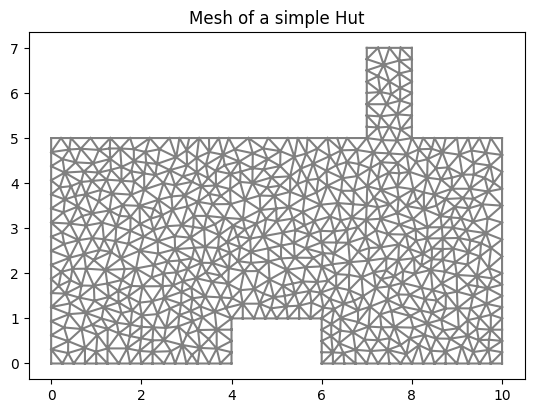

In [4]:
# Create empty Mesh 
mesh = Mesh()

# Create list of polygonal domain vertices
domain_vertices = [
    Point(0.0, 0.0), # edge of house
    Point(4.0, 0.0), # edge fireplace
    Point(4.0, 1.0), # edge fireplace
    Point(6.0, 1.0), # edge fireplace
    Point(6.0, 0.0), # edge fireplace
    Point(10.0, 0.0), # edge of house
    Point(10.0, 1.0), # edge window
    Point(10.0, 2.0), # edge window
    Point(10.0, 5.0), # edge of house
    Point(8.0, 5.0), # edge chimney
    Point(8.0, 7.0), # edge chimney
    Point(7.0, 7.0), # edge chimney
    Point(7.0, 5.0), # edge chimney
    Point(0.0, 5.0), # edge of house
]

domain = Polygon(domain_vertices)
mesh = generate_mesh(domain, 20)
plot(mesh)
plt.title("Mesh of a simple Hut")
plt.show()
V = FunctionSpace(mesh, 'P', 1)

In [5]:
# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, mesh.topology().dim())  # CellFunction
domains.set_all(0)

# Define new measures associated with the interior domains
dx = Measure("dx", domain=mesh, subdomain_data=domains)

# Define the boundaries
wall_thick = 0.5 # 0.5
roof_thick = 0.8 # 0.8
chimney_thick = 0.2 # 0.2
floor_thick = 0.5 # 0.5
window_thick = 0.06 # 0.06
fireplace_thick = 0.1 # 0.10

class Wall(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (
            near(x[0], 0)
            or (near(x[0], 10) and x[1] <= 1)
            or (near(x[0], 10) and x[1] >= 2)
        )

class Roof(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (
            (near(x[1], 5) and x[0] <= 7) or (near(x[1], 5) and x[0] >= 8)
        )

class Chimney(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (
            (near(x[0], 7) and x[1] >= 5)
            or (near(x[0], 8) and x[1] >= 5)
            or (near(x[1], 7))
        )

class Floor(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0) and (x[0] <= 4 or x[0] >= 6)

class Window(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], 10) and between(x[1], (1, 3.5)))

class Fire(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[1], 1) and between(x[0], (4, 6)))

class Brick(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], 4) and x[1] <= 1) or (near(x[0], 6) and x[1] <= 1)

class Obstacle(SubDomain):
    def inside(self, x, on_boundary):
        return between(x[1], (0.5, 0.7)) and between(x[0], (0.2, 1.0))


# create a cell function over the boundaries edges
sub_boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1) # mesh.topology().dim()-1
# set marker to 6
sub_boundaries.set_all(0)

wall = Wall()
wall.mark(sub_boundaries, 1)

roof = Roof()
roof.mark(sub_boundaries, 2)

chimney = Chimney()
chimney.mark(sub_boundaries, 3)

floor = Floor()
floor.mark(sub_boundaries, 4)

window = Window()
window.mark(sub_boundaries, 5)

fire = Fire()
fire.mark(sub_boundaries, 6)

brick = Brick()
brick.mark(sub_boundaries, 7)

# redefining integrals over boundaries
ds = Measure('ds', domain=mesh, subdomain_data=sub_boundaries)
#ds(1) = Gamma_wall ds(2) = Gamma_roof ; ds(3) = Gamma_chimney ; ds(4) = Gamma_floor ; ds(5) = gamma_

In [6]:
##########################
# Diffusivity function mu
mu0 = 19e-3 # [units=?] and corresponding to what material ? 
#mu0 = 1.
print("The diffusivity constant mu0 = ",mu0)
m = 5 # power-law exponent (in the case of non-linear law)
def mu(u):
    return mu0 * u**m
def dmu(u):
    return m * mu0 * u**(m-1)

The diffusivity constant mu0 =  0.019


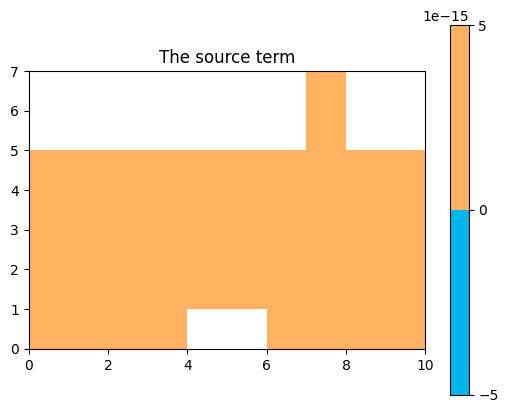

In [7]:
##############
# Source term
# fp_exp = Expression(('1e+2*exp(-pow((x[0]-0.5),2)/0.02 - pow((x[1]-0.5),2)/0.02)'), element = V.ufl_element())
fp_exp = Expression(('0.'), element = V.ufl_element())
fp = interpolate(fp_exp,V)
# Plot
p = plot(fp,title='The source term')
p.set_cmap("rainbow"); plt.colorbar(p); plt.show()

In [8]:
#######
# BCs

# Dirichlet BCs: non homogenous and homogeneous ones
u_diri_val = 3.e2
u_diri_non_hom_exp = Expression('3.e2', element = V.ufl_element()) 
u_diri_non_hom = interpolate(u_diri_non_hom_exp,V)
bc_non_hom = DirichletBC(V, u_diri_non_hom_exp, u_bdry_x0)
#print("The imposed Dirichlet value =", u_diri_non_hom)

u_diri0_exp = Expression('3.',element = V.ufl_element())
bc0 = DirichletBC(V, u_diri0_exp, u_bdry_x0)
bc1 = DirichletBC(V, u_diri0_exp, u_bdry_x1)
bcs = [bc0, bc1]

# Fluxes BC coefficients
#    Recall: flux BCs are imposed in the weak form
#c = 1. # coeff. value of the flux condition (Robin like condition)
c = 5.65e-8 # Stefan's constant value
q = 4 # the power-law index of the flux law 
u_ref_val = 3.3e2
u_ref_exp = Expression('3.3e2', element = V.ufl_element()) 
u_ref = interpolate(u_ref_exp,V)
print("The non-linear flux coefficients are: (c, q, u_ref) = ", (c,q,u_ref_val))

The non-linear flux coefficients are: (c, q, u_ref) =  (5.65e-08, 4, 330.0)


## 3) Simulations

In [9]:
# Set tolerance
tolerance = 1e-6

# Define initial condition u(x, 0) = 3
u_n = Function(V)
u_n.assign(Constant(3.0))

# Define constants
dt = 50
T = 10000
num_steps = int(T / dt)


### The variational formula

$$ \int_Ω \partial_t uv + \int_Ω \mu \nabla u \nabla v + \int_{\Gamma_{Flux}} c(x) u v + \int_{\Gamma_{fire}} \sigma u^4 v = \int_Ω fv + \int_{\Gamma_{fire}} \sigma  u_f^4 v$$
Recall the $\theta$-scheme:
$$ M\frac{U_{n+1} - U_n}{\Delta t} + A(\theta U_{n+1} + (1-\theta)U_n) = \theta F_{n+1} + (1-\theta)F_n $$
For simplicity and stability, let's consider the Backward Euler method ($\theta=1$), which is an implicit method. This method approximates the time derivative as follows:
$$ \partial_t ≈ \frac{u_{n+1} - u_n}{\Delta t} $$

This results in the variational formulation:
$$ \int_Ω \frac{u_{n+1}}{\Delta t}v + \int_Ω \mu \nabla u_{n+1} \nabla v + \int_{\Gamma_{Flux}} c(x) u_{n+1} v + \int_{\Gamma_{fire}} \sigma u_{n+1}^4 v =\int_Ω \frac{u_n}{\Delta t}v + \int_Ω fv + \int_{\Gamma_{fire}} \sigma  u_f^4 v$$


Time step 0: norm of difference = 1295.1839267154842


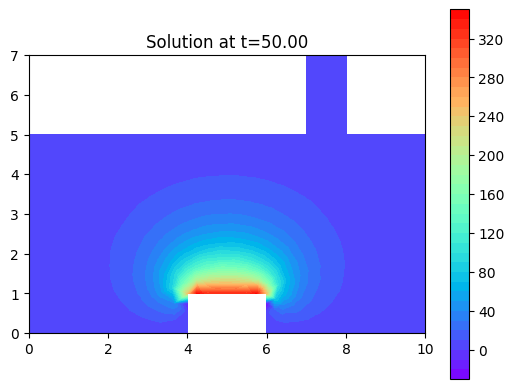

Time step 1: norm of difference = 317.36051450364204
Time step 2: norm of difference = 173.04433007191636
Time step 3: norm of difference = 105.35442136685853
Time step 4: norm of difference = 66.08734969590155
Time step 5: norm of difference = 41.86454076844856
Time step 6: norm of difference = 26.61754684449285
Time step 7: norm of difference = 16.948987790121887
Time step 8: norm of difference = 10.799551098125722
Time step 9: norm of difference = 6.883326859050246
Time step 10: norm of difference = 4.387859611348411


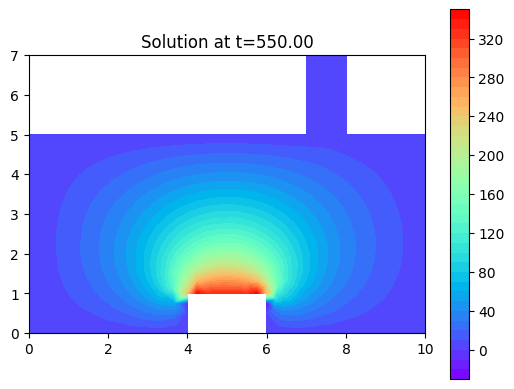

Time step 11: norm of difference = 2.7972866567013326
Time step 12: norm of difference = 1.7833487462529396
Time step 13: norm of difference = 1.136955777784043
Time step 14: norm of difference = 0.7248621480536911
Time step 15: norm of difference = 0.4621363315816409
Time step 16: norm of difference = 0.2946366320234141
Time step 17: norm of difference = 0.18784722767698078
Time step 18: norm of difference = 0.11976334790277583
Time step 19: norm of difference = 0.07635613232238592
Time step 20: norm of difference = 0.0486815719243138


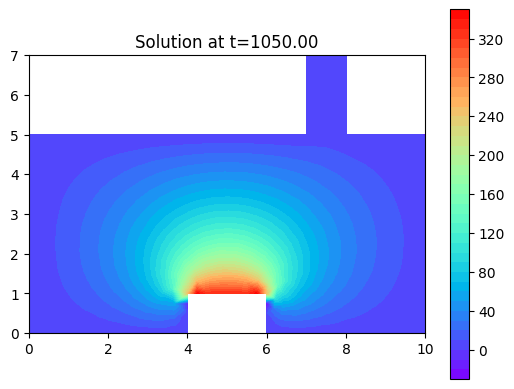

Time step 21: norm of difference = 0.031037433200861556
Time step 22: norm of difference = 0.019788251349210015
Time step 23: norm of difference = 0.012616222986642086
Time step 24: norm of difference = 0.008043619762505734
Time step 25: norm of difference = 0.005128305409220965
Time step 26: norm of difference = 0.003269612985512973
Time step 27: norm of difference = 0.00208458158064671
Time step 28: norm of difference = 0.0013290505132262415
Time step 29: norm of difference = 0.000847352468462396
Time step 30: norm of difference = 0.0005402399681306521


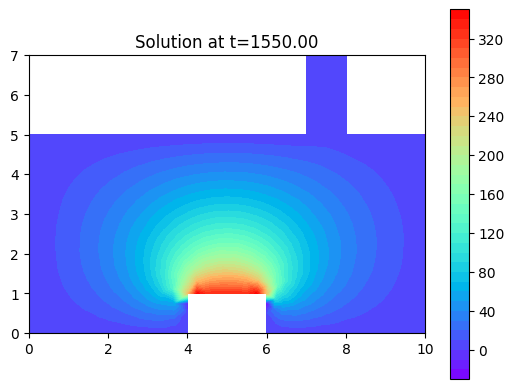

Time step 31: norm of difference = 0.0003444366128727736
Time step 32: norm of difference = 0.0002195997720376556
Time step 33: norm of difference = 0.00014000850817245982
Time step 34: norm of difference = 8.926412213991173e-05
Time step 35: norm of difference = 5.691141838439489e-05
Time step 36: norm of difference = 3.628455852177771e-05
Time step 37: norm of difference = 2.313365383322321e-05
Time step 38: norm of difference = 1.474913652598343e-05
Time step 39: norm of difference = 9.403486843014415e-06
Time step 40: norm of difference = 5.995303855008694e-06


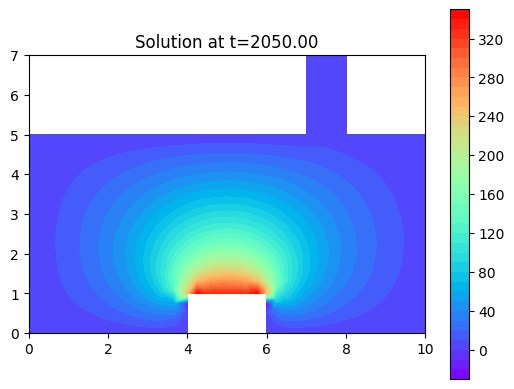

Time step 41: norm of difference = 3.82237630227561e-06
Time step 42: norm of difference = 2.437000945307115e-06
Time step 43: norm of difference = 1.5537382902626095e-06
Time step 44: norm of difference = 9.906038757393296e-07
Convergence achieved at time step 44, t = 2250
Time-stepping loop finished


In [10]:
######################################
# Initial solution ("first guess") u0
# u0 = solution of a semi-linearized BVP
######################################
# Case mu constant diffusivity. Non-linear term : non-linear flux
#mu0_diri = mu( interpolate(u_diri_exp_1,V) )

# Define variational problem for time-stepping
u = TrialFunction(V)
v = TestFunction(V)

# Time-stepping loop
t = 0
for n in range(num_steps):
    t += dt
    
    # Update u_ref if needed, here it is constant
    a = (
        (u/dt)*v*dx + 
        mu0 * inner(grad(u), grad(v)) * dx  + 
        c * (u_ref**(q-1) * u) * v * ds(6) + 
        wall_thick*u*v*ds(1) +
        roof_thick*u*v*ds(2) +
        chimney_thick*u*v*ds(3) +
        floor_thick*u*v*ds(4) +
        window_thick*u*v*ds(5) +
        wall_thick*u*v*ds(7)
    )
    L = (u_n/dt)*v*dx + fp*v*dx + c * (u_ref**q) * v * ds(6)
    
    u_new = Function(V)
    solve(a == L, u_new)

    # Check for convergence
    diff = u_new.vector() - u_n.vector()
    norm_diff = norm(diff, 'L2')
    
    print(f"Time step {n}: norm of difference = {norm_diff}")
    
    if norm_diff < tolerance:
        print(f"Convergence achieved at time step {n}, t = {t}")
        break
        
    # Update previous solution
    u_n.assign(u_new)
    
    # Plot or save the solution for visualization every few steps
    if n % 10 == 0 or n == num_steps - 1:
        plt.figure()
        p = plot(u_new, title=f'Solution at t={t:.2f}')
        p.set_cmap("rainbow")
        plt.colorbar(p)
        plt.show(block=False)

print("Time-stepping loop finished")

## 3.2) Increasing model complexity...

In [11]:
w = Constant((0.05, 0.0))  # example wind field

Time step 0: norm of difference = 1289.7045826706483


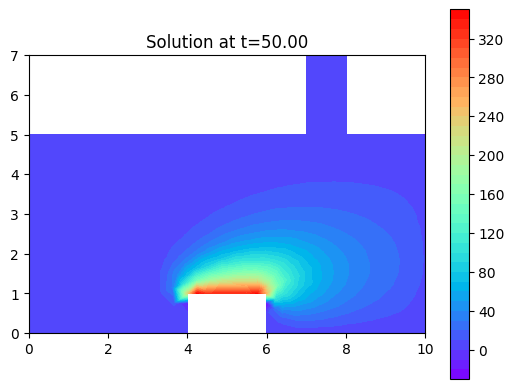

Time step 1: norm of difference = 303.6801387161888


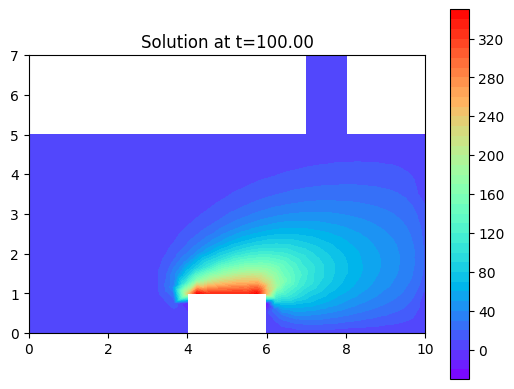

Time step 2: norm of difference = 140.91366065056235


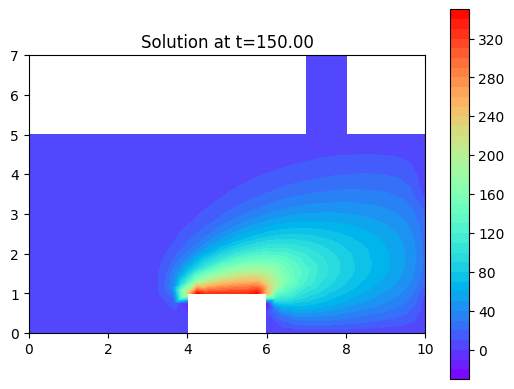

Time step 3: norm of difference = 63.14168063745061


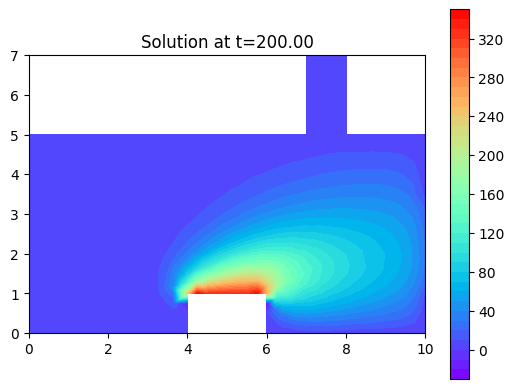

Time step 4: norm of difference = 26.17443820905034


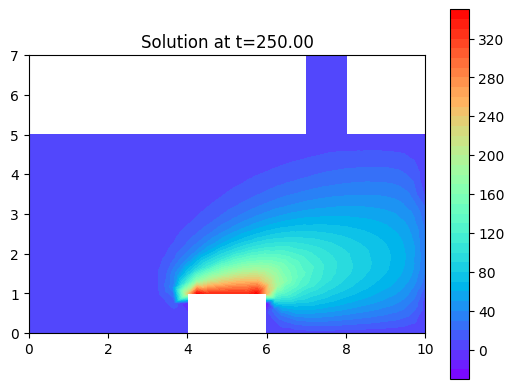

Time step 5: norm of difference = 10.108407165998335


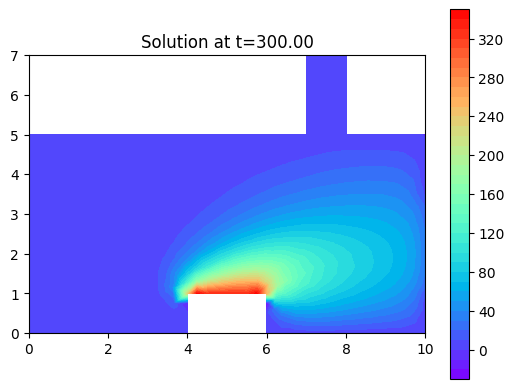

Time step 6: norm of difference = 3.677003768092078


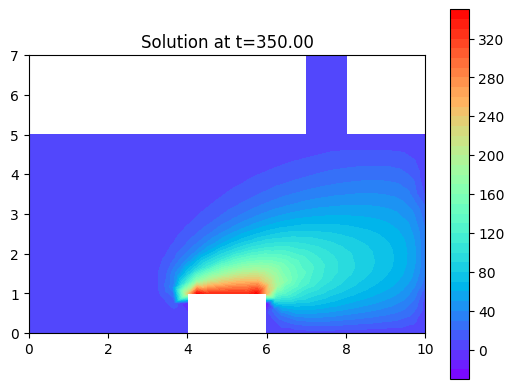

Time step 7: norm of difference = 1.2708586737543526


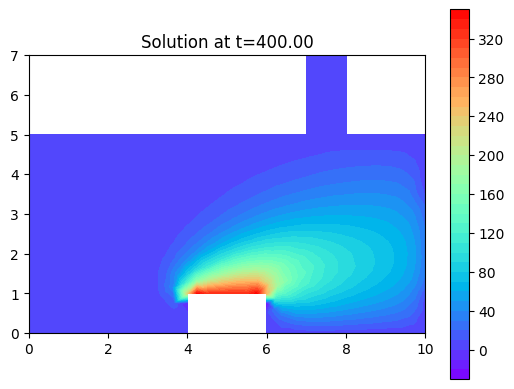

Time step 8: norm of difference = 0.4198126933018471


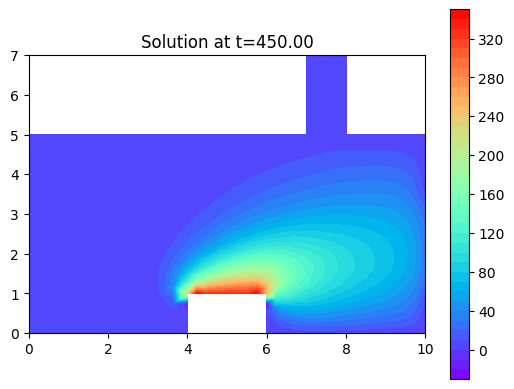

Time step 9: norm of difference = 0.1329842906214194


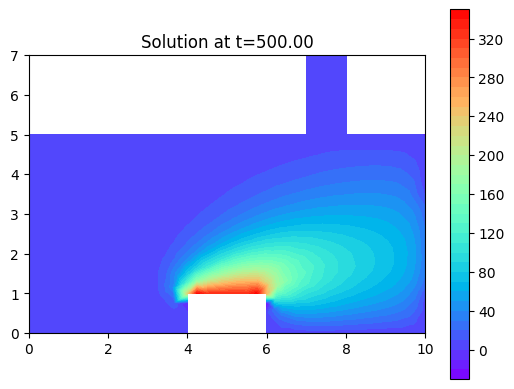

Time step 10: norm of difference = 0.040426410455387


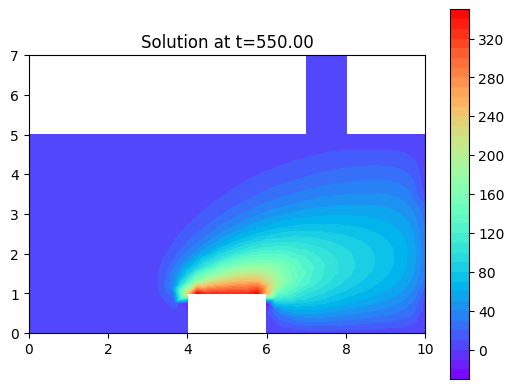

Time step 11: norm of difference = 0.011769304364330177


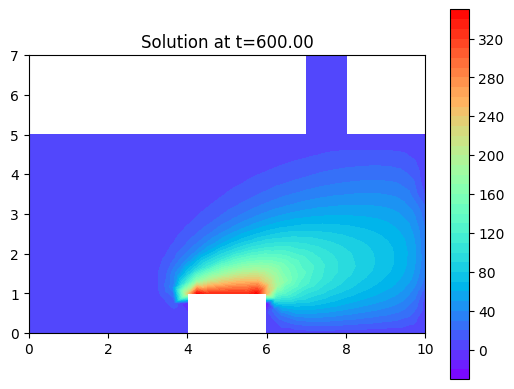

Time step 12: norm of difference = 0.0032622717386964254


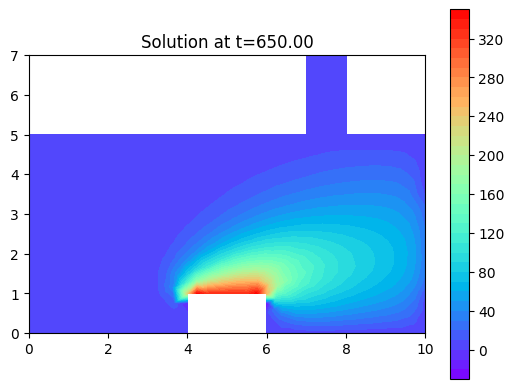

Time step 13: norm of difference = 0.000851110297192446


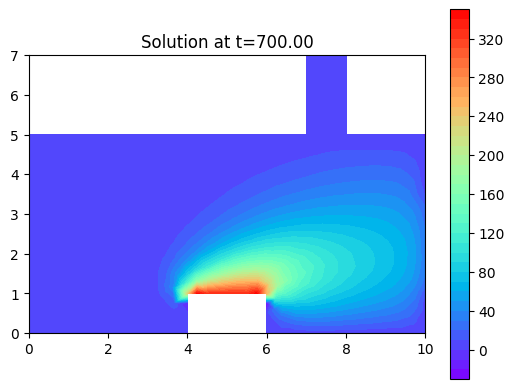

Time step 14: norm of difference = 0.00020499871440111887


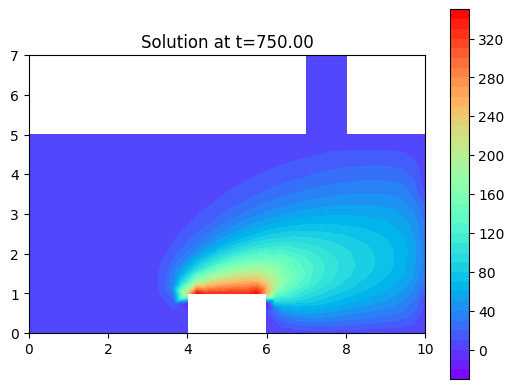

Time step 15: norm of difference = 4.491270307536754e-05


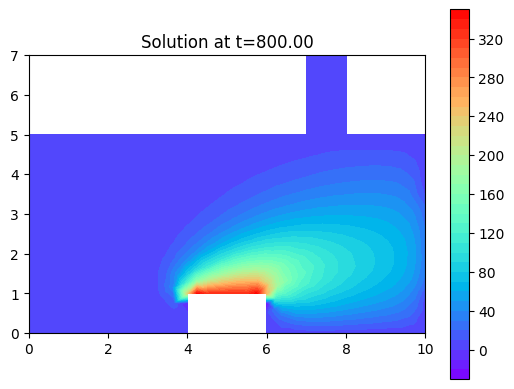

Time step 16: norm of difference = 1.0463450429406336e-05


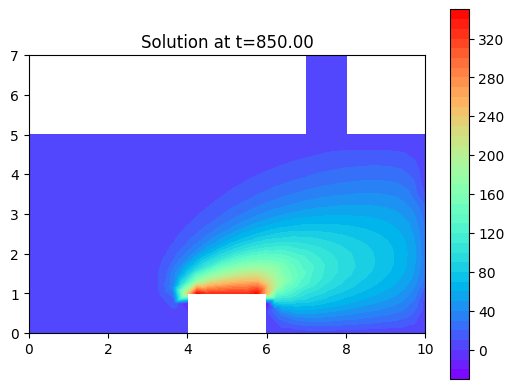

Time step 17: norm of difference = 4.1544502904999964e-06


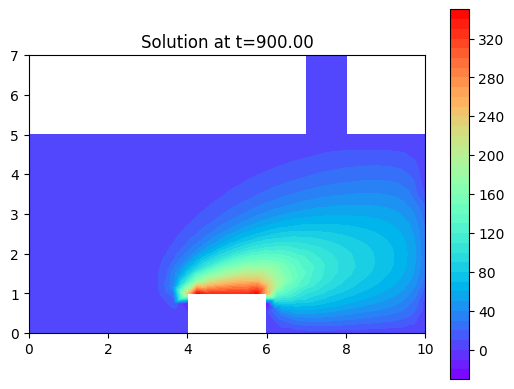

Time step 18: norm of difference = 2.0194461423432207e-06


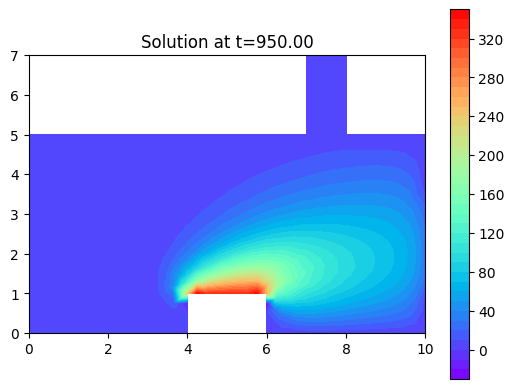

Time step 19: norm of difference = 9.057303094158961e-07
Convergence achieved at time step 19, t = 1000
Time-stepping loop finished


In [12]:
######################################
# Initial solution ("first guess") u0
# u0 = solution of a semi-linearized BVP
######################################
# Case mu constant diffusivity. Non-linear term : non-linear flux
#mu0_diri = mu( interpolate(u_diri_exp_1,V) )

# Set tolerance
tolerance = 1e-6

# Define initial condition u(x, 0) = 3
u_n = Function(V)
u_n.assign(Constant(3.0))

# Define constants
dt = 50
T = 10000
num_steps = int(T / dt)

# Define variational problem for time-stepping
u = TrialFunction(V)
v = TestFunction(V)

# Time-stepping loop
t = 0
for n in range(num_steps):
    t += dt
    
    # Update u_ref if needed, here it is constant
    a = (
        (u/dt)*v*dx + 
        mu0 * inner(grad(u), grad(v)) * dx  + 
        inner(w, grad(u)) * v * dx + # Introduce convective transfers
        c * (u_ref**(q-1) * u) * v * ds(6) + 
        wall_thick*u*v*ds(1) +
        roof_thick*u*v*ds(2) +
        chimney_thick*u*v*ds(3) +
        floor_thick*u*v*ds(4) +
        window_thick*u*v*ds(5) +
        wall_thick*u*v*ds(7)
    )
    L = (u_n/dt)*v*dx + fp*v*dx + c * (u_ref**q) * v * ds(6)
    
    u_new = Function(V)
    solve(a == L, u_new)

    # Check for convergence
    diff = u_new.vector() - u_n.vector()
    norm_diff = norm(diff, 'L2')
    
    print(f"Time step {n}: norm of difference = {norm_diff}")
    
    if norm_diff < tolerance:
        print(f"Convergence achieved at time step {n}, t = {t}")
        break
        
    # Update previous solution
    u_n.assign(u_new)
    
    # Plot or save the solution for visualization every few steps
    if n % 1 == 0 or n == num_steps - 1:
        plt.figure()
        p = plot(u_new, title=f'Solution at t={t:.2f}')
        p.set_cmap("rainbow")
        plt.colorbar(p)
        plt.show(block=False)

print("Time-stepping loop finished")

### The variational formula

$$ \int_Ω \partial_t uv + \int_Ω \mu \nabla u \nabla v + \int_{\Gamma_{Flux}} c(x) u v + \int_{\Gamma_{fire}} \sigma u^4 v = \int_Ω fv + \int_{\Gamma_{fire}} \sigma  u_f^4 v$$
Again, we consider the $\theta$-scheme:
$$ M\frac{U_{n+1} - U_n}{\Delta t} + A(\theta U_{n+1} + (1-\theta)U_n) = \theta F_{n+1} + (1-\theta)F_n $$
We simulate the Crank-Nicholson method ($\theta=0.5$), which is an implicit order 2 method.This results in the variational formulation:
$$ \int_Ω \frac{u_{n+1}}{\Delta t}v + \int_Ω 0.5 \mu \nabla u_{n+1} \nabla v + \int_{\Gamma_{Flux}} 0.5 c(x) u_{n+1} v + \int_{\Gamma_{fire}} 0.5 \sigma u_{n+1}^4 v $$
$$=\int_Ω \frac{u_n}{\Delta t}v - \int_Ω 0.5 \mu \nabla u_{n} \nabla v - \int_{\Gamma_{Flux}} 0.5 c(x) u_{n} v - \int_{\Gamma_{fire}} 0.5 \sigma u_{n}^4 v + \int_Ω fv + \int_{\Gamma_{fire}} \sigma  u_f^4 v$$


Time step 0: norm of difference = 685.4360899479793


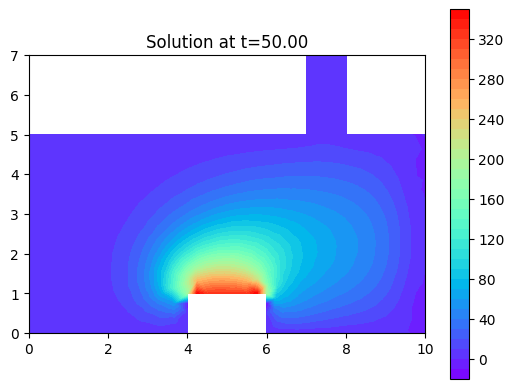

Time step 1: norm of difference = 259.563050664948
Time step 2: norm of difference = 138.20210716879217
Time step 3: norm of difference = 90.40320798791066
Time step 4: norm of difference = 66.23997304346554
Time step 5: norm of difference = 53.35670742354997
Time step 6: norm of difference = 44.56000343952724
Time step 7: norm of difference = 38.479013584212666
Time step 8: norm of difference = 33.76185946882161
Time step 9: norm of difference = 30.082415419180716
Time step 10: norm of difference = 27.080323358160836


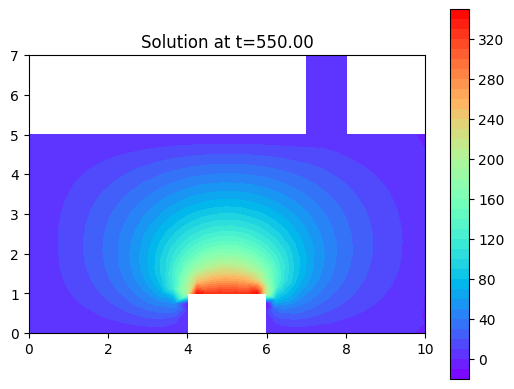

Time step 11: norm of difference = 24.604734351011192
Time step 12: norm of difference = 22.519608021993317
Time step 13: norm of difference = 20.743938897649603
Time step 14: norm of difference = 19.212595412641736
Time step 15: norm of difference = 17.879716045150506
Time step 16: norm of difference = 16.709311676526394
Time step 17: norm of difference = 15.673994730932085
Time step 18: norm of difference = 14.752024426634822
Time step 19: norm of difference = 13.926158140961064
Time step 20: norm of difference = 13.18243151859674


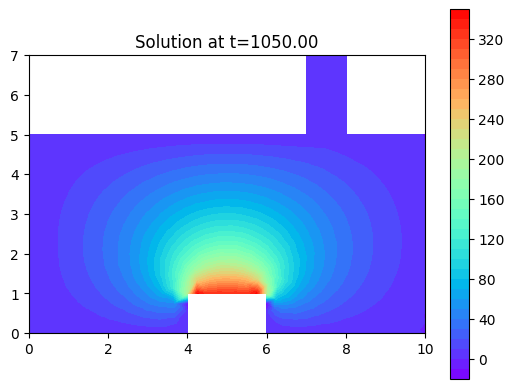

Time step 21: norm of difference = 12.509468229056942
Time step 22: norm of difference = 11.897875154930087
Time step 23: norm of difference = 11.339844973385354
Time step 24: norm of difference = 10.82882387339184
Time step 25: norm of difference = 10.359276509371467
Time step 26: norm of difference = 9.926491462094754
Time step 27: norm of difference = 9.526436643217474
Time step 28: norm of difference = 9.155639824387734
Time step 29: norm of difference = 8.811096359715961
Time step 30: norm of difference = 8.490192832611209


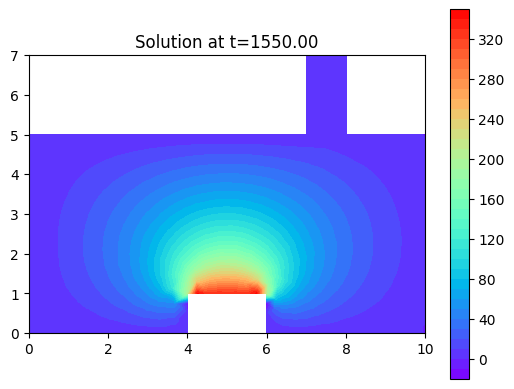

Time step 31: norm of difference = 8.190646286675234
Time step 32: norm of difference = 7.910453744472744
Time step 33: norm of difference = 7.6478511005487855
Time step 34: norm of difference = 7.4012787704139225
Time step 35: norm of difference = 7.169353229312061
Time step 36: norm of difference = 6.950843058593549
Time step 37: norm of difference = 6.744648831505759
Time step 38: norm of difference = 6.549786055834463
Time step 39: norm of difference = 6.365370696141143
Time step 40: norm of difference = 6.1906068035601125


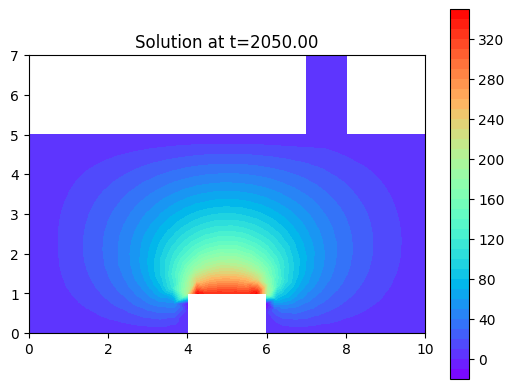

Time step 41: norm of difference = 6.024775922165368
Time step 42: norm of difference = 5.867227972309012
Time step 43: norm of difference = 5.717373383021676
Time step 44: norm of difference = 5.574676275856244
Time step 45: norm of difference = 5.438648542611067
Time step 46: norm of difference = 5.3088446827557805
Time step 47: norm of difference = 5.184857290587312
Time step 48: norm of difference = 5.066313098947084
Time step 49: norm of difference = 4.952869501818161
Time step 50: norm of difference = 4.8442114899169875


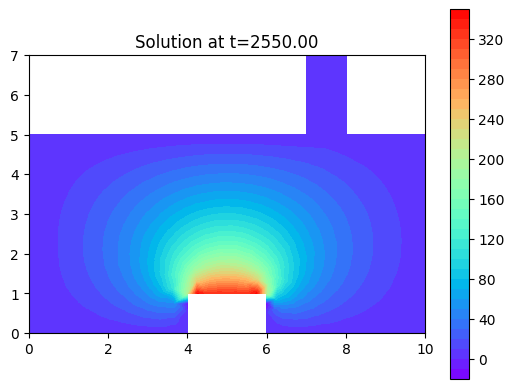

Time step 51: norm of difference = 4.74004894370307
Time step 52: norm of difference = 4.640114236482002
Time step 53: norm of difference = 4.544160107333972
Time step 54: norm of difference = 4.451957769404277
Time step 55: norm of difference = 4.363295224023246
Time step 56: norm of difference = 4.277975755246013
Time step 57: norm of difference = 4.195816582905234
Time step 58: norm of difference = 4.116647655229442
Time step 59: norm of difference = 4.040310564604518
Time step 60: norm of difference = 3.966657572205275


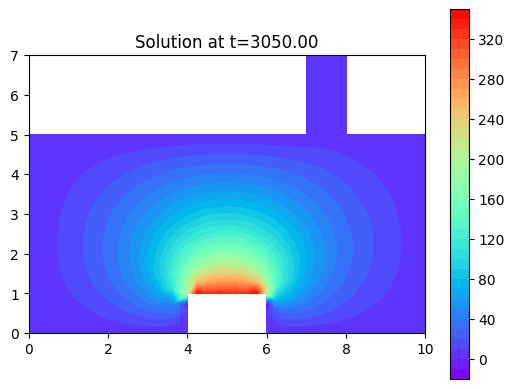

Time step 61: norm of difference = 3.8955507290647886
Time step 62: norm of difference = 3.8268610827276373
Time step 63: norm of difference = 3.7604679599916713
Time step 64: norm of difference = 3.6962583174136068
Time step 65: norm of difference = 3.6341261522660466
Time step 66: norm of difference = 3.5739719675107082
Time step 67: norm of difference = 3.51570228511381
Time step 68: norm of difference = 3.459229202693089
Time step 69: norm of difference = 3.4044699890632173
Time step 70: norm of difference = 3.351346714751628


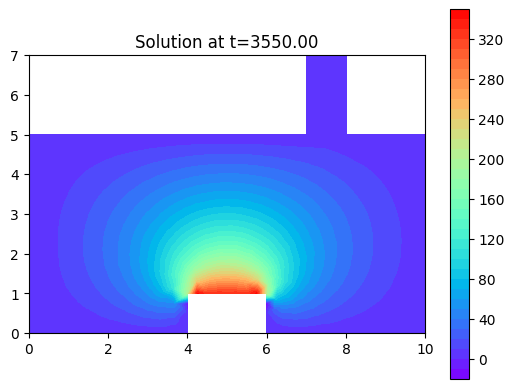

Time step 71: norm of difference = 3.2997859139984884
Time step 72: norm of difference = 3.249718275142747
Time step 73: norm of difference = 3.2010783566362027
Time step 74: norm of difference = 3.1538043262268665
Time step 75: norm of difference = 3.1078377211178383
Time step 76: norm of difference = 3.0631232271401094
Time step 77: norm of difference = 3.0196084751839294
Time step 78: norm of difference = 2.977243853315623
Time step 79: norm of difference = 2.935982333168808
Time step 80: norm of difference = 2.8957793093414717


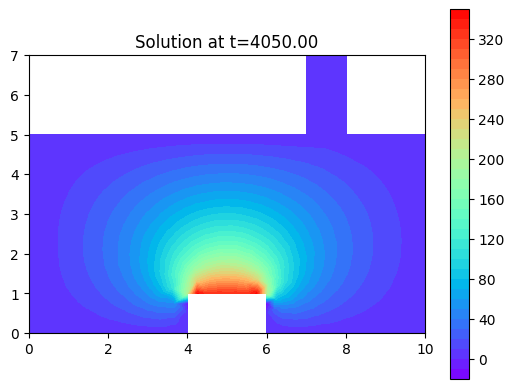

Time step 81: norm of difference = 2.856592450658422
Time step 82: norm of difference = 2.8183815622721684
Time step 83: norm of difference = 2.7811084576756806
Time step 84: norm of difference = 2.744736839791113
Time step 85: norm of difference = 2.709232190378711
Time step 86: norm of difference = 2.6745616670817545
Time step 87: norm of difference = 2.640694007488582
Time step 88: norm of difference = 2.6075994396496434
Time step 89: norm of difference = 2.5752495985391475
Time step 90: norm of difference = 2.543617447997758


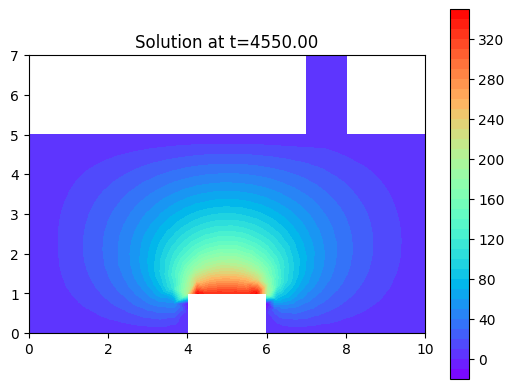

Time step 91: norm of difference = 2.5126772077344213
Time step 92: norm of difference = 2.4824042850025476
Time step 93: norm of difference = 2.4527752105997003
Time step 94: norm of difference = 2.423767578870725
Time step 95: norm of difference = 2.395359991421282
Time step 96: norm of difference = 2.3675320042742207
Time step 97: norm of difference = 2.340264078222789
Time step 98: norm of difference = 2.3135375321555465
Time step 99: norm of difference = 2.287334499146532
Time step 100: norm of difference = 2.2616378851204098


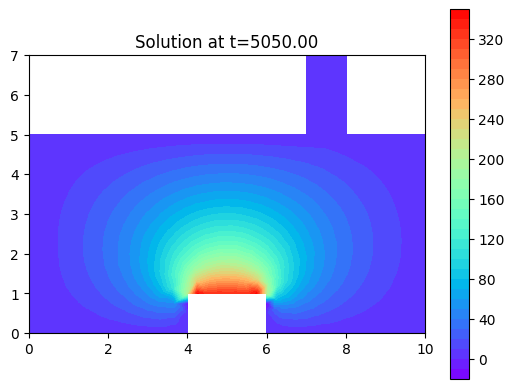

Time step 101: norm of difference = 2.236431329917657
Time step 102: norm of difference = 2.2116991705988553
Time step 103: norm of difference = 2.187426406839565
Time step 104: norm of difference = 2.163598668278569
Time step 105: norm of difference = 2.1402021836929395
Time step 106: norm of difference = 2.1172237518826305
Time step 107: norm of difference = 2.094650714156335
Time step 108: norm of difference = 2.0724709283180793
Time step 109: norm of difference = 2.0506727440612407
Time step 110: norm of difference = 2.0292449796835133


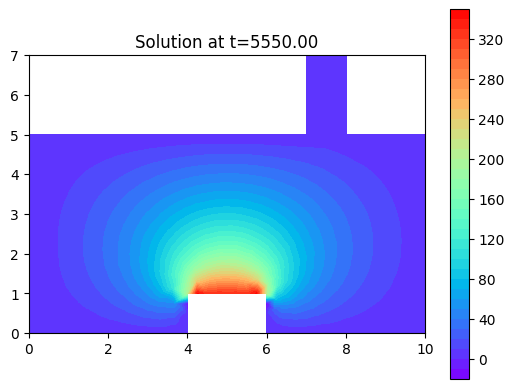

Time step 111: norm of difference = 2.008176900042449
Time step 112: norm of difference = 1.9874581956769026
Time step 113: norm of difference = 1.9670789630245975
Time step 114: norm of difference = 1.947029685670881
Time step 115: norm of difference = 1.9273012165686456
Time step 116: norm of difference = 1.9078847611727217
Time step 117: norm of difference = 1.8887718614358968
Time step 118: norm of difference = 1.8699543806176862
Time step 119: norm of difference = 1.8514244888596827
Time step 120: norm of difference = 1.8331746494843513


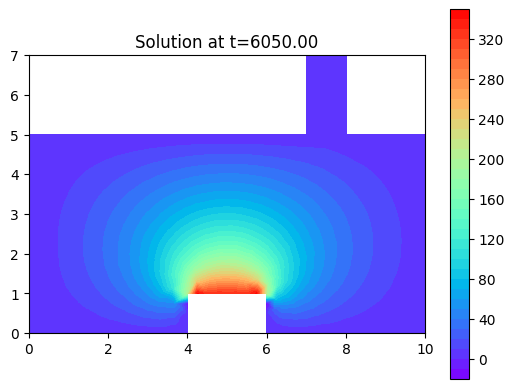

Time step 121: norm of difference = 1.8151976059769144
Time step 122: norm of difference = 1.7974863696126384
Time step 123: norm of difference = 1.7800342076940099
Time step 124: norm of difference = 1.76283463236448
Time step 125: norm of difference = 1.7458813899674048
Time step 126: norm of difference = 1.7291684509212804
Time step 127: norm of difference = 1.7126900000832976
Time step 128: norm of difference = 1.6964404275753329
Time step 129: norm of difference = 1.6804143200480575
Time step 130: norm of difference = 1.6646064523601227


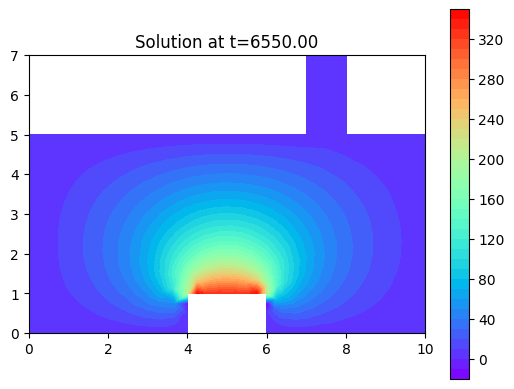

Time step 131: norm of difference = 1.649011779650918
Time step 132: norm of difference = 1.633625429786136
Time step 133: norm of difference = 1.6184426961573086
Time step 134: norm of difference = 1.603459030817168
Time step 135: norm of difference = 1.588670037933176
Time step 136: norm of difference = 1.5740714675436318
Time step 137: norm of difference = 1.559659209601029
Time step 138: norm of difference = 1.5454292882879894
Time step 139: norm of difference = 1.5313778565921978
Time step 140: norm of difference = 1.5175011911276293


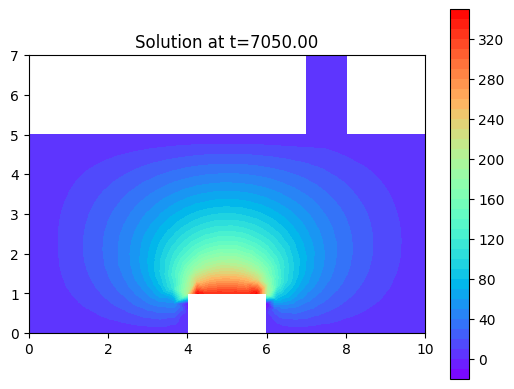

Time step 141: norm of difference = 1.503795687189881
Time step 142: norm of difference = 1.4902578540337268
Time step 143: norm of difference = 1.4768843103623008
Time step 144: norm of difference = 1.4636717800177115
Time step 145: norm of difference = 1.4506170878628732
Time step 146: norm of difference = 1.4377171558456348
Time step 147: norm of difference = 1.4249689992362369
Time step 148: norm of difference = 1.4123697230297354
Time step 149: norm of difference = 1.3999165185058873
Time step 150: norm of difference = 1.387606659938524


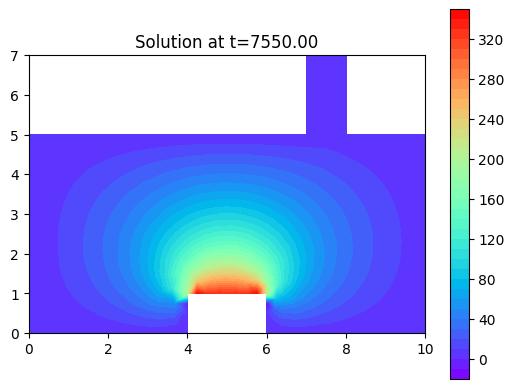

Time step 151: norm of difference = 1.3754375014474736
Time step 152: norm of difference = 1.3634064739864833
Time step 153: norm of difference = 1.3515110824605792
Time step 154: norm of difference = 1.339748902966721
Time step 155: norm of difference = 1.3281175801521596
Time step 156: norm of difference = 1.3166148246849483
Time step 157: norm of difference = 1.3052384108314499
Time step 158: norm of difference = 1.2939861741357783
Time step 159: norm of difference = 1.2828560091966543
Time step 160: norm of difference = 1.2718458675371953


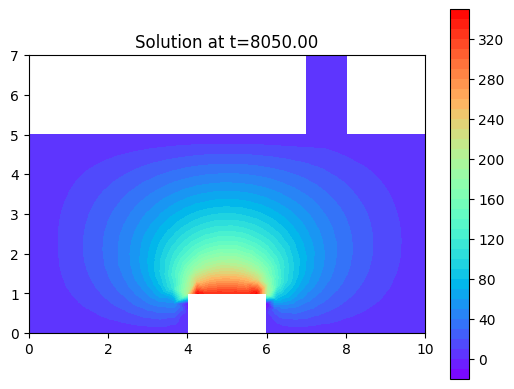

Time step 161: norm of difference = 1.260953755563016
Time step 162: norm of difference = 1.250177732605251
Time step 163: norm of difference = 1.2395159090443377
Time step 164: norm of difference = 1.2289664445106439
Time step 165: norm of difference = 1.2185275461589478
Time step 166: norm of difference = 1.2081974670131668
Time step 167: norm of difference = 1.1979745043783114
Time step 168: norm of difference = 1.187856998316693
Time step 169: norm of difference = 1.1778433301852902
Time step 170: norm of difference = 1.167931921231862


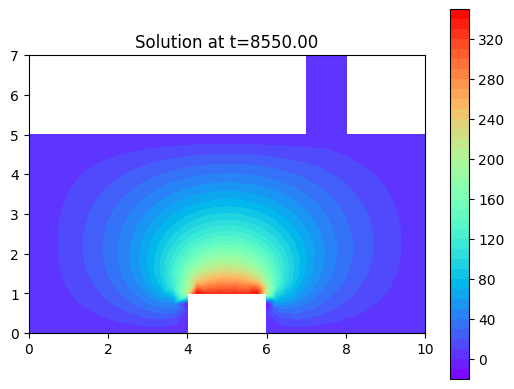

Time step 171: norm of difference = 1.1581212312471876
Time step 172: norm of difference = 1.1484097572708483
Time step 173: norm of difference = 1.138796032348145
Time step 174: norm of difference = 1.1292786243360124
Time step 175: norm of difference = 1.1198561347560076
Time step 176: norm of difference = 1.110527197691995
Time step 177: norm of difference = 1.1012904787307722
Time step 178: norm of difference = 1.0921446739436569
Time step 179: norm of difference = 1.083088508907401
Time step 180: norm of difference = 1.074120737762934


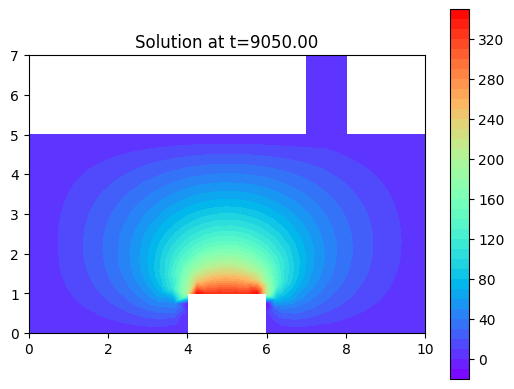

Time step 181: norm of difference = 1.0652401423099525
Time step 182: norm of difference = 1.0564455311358785
Time step 183: norm of difference = 1.0477357387780613
Time step 184: norm of difference = 1.0391096249175036
Time step 185: norm of difference = 1.0305660736028965
Time step 186: norm of difference = 1.0221039925037647
Time step 187: norm of difference = 1.0137223121913692
Time step 188: norm of difference = 1.0054199854463182
Time step 189: norm of difference = 0.9971959865916367
Time step 190: norm of difference = 0.98904931085053


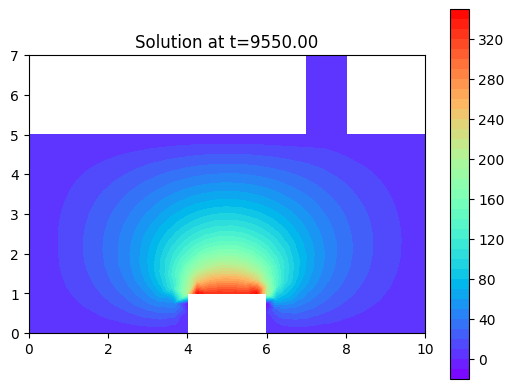

Time step 191: norm of difference = 0.980978973727564
Time step 192: norm of difference = 0.9729840104122764
Time step 193: norm of difference = 0.9650634752045305
Time step 194: norm of difference = 0.9572164409606118
Time step 195: norm of difference = 0.9494419985592084
Time step 196: norm of difference = 0.941739256386347
Time step 197: norm of difference = 0.9341073398387874
Time step 198: norm of difference = 0.9265453908450547
Time step 199: norm of difference = 0.9190525674032178


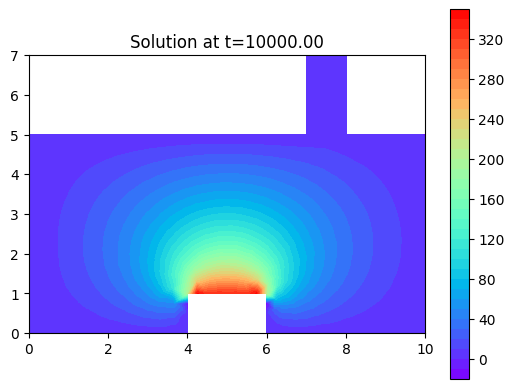

Time-stepping loop finished


In [13]:
# Define variational problem for time-stepping
u = TrialFunction(V)
v = TestFunction(V)

# Time-stepping loop
t = 0
for n in range(num_steps):
    t += dt
    
    # Update u_ref if needed, here it is constant
    a = (
        (u/dt)*v*dx + 
        0.5*mu0 * inner(grad(u), grad(v)) * dx  + 
        0.5*c * (u_ref**(q-1) * u) * v * ds(6) + 
        0.5*wall_thick*u*v*ds(1) +
        0.5*roof_thick*u*v*ds(2) +
        0.5*chimney_thick*u*v*ds(3) +
        0.5*floor_thick*u*v*ds(4) +
        0.5*window_thick*u*v*ds(5) +
        0.5*wall_thick*u*v*ds(7)
    )
    L = (
        - 0.5*mu0 * inner(grad(u_n), grad(v)) * dx 
        - 0.5*c * (u_n*q) * v * ds(6)
        - 0.5*wall_thick*u_n*v*ds(1)
        - 0.5*roof_thick*u_n*v*ds(2) 
        - 0.5*chimney_thick*u_n*v*ds(3)
        - 0.5*floor_thick*u_n*v*ds(4)
        - 0.5*window_thick*u_n*v*ds(5)
        - 0.5*wall_thick*u_n*v*ds(7) +
        (u_n/dt)*v*dx + 
        fp*v*dx +
        0.5*c * (u_ref**q) * v * ds(6)
    )
    u_new = Function(V)
    solve(a == L, u_new)

    # Check for convergence
    diff = u_new.vector() - u_n.vector()
    norm_diff = norm(diff, 'L2')
    
    print(f"Time step {n}: norm of difference = {norm_diff}")
    
    if norm_diff < tolerance:
        print(f"Convergence achieved at time step {n}, t = {t}")
        break
        
    # Update previous solution
    u_n.assign(u_new)
    
    # Plot or save the solution for visualization every few steps
    if n % 10 == 0 or n == num_steps - 1:
        plt.figure()
        p = plot(u_new, title=f'Solution at t={t:.2f}')
        p.set_cmap("rainbow")
        plt.colorbar(p)
        plt.show(block=False)

print("Time-stepping loop finished")

## Simple model to define the fluid velocity w
You here compute the fluid velocity w by solving a basic fluid flow model, namely the potential flow model. The fluid velocity is assumed to derive from apotentialV :$w=∇V$.
Assuming a steady-state flow and using the incompressibility assumption $div(w) = 0$, it follows the equations :
$−\Delta V(x,t) = 0 \ in\  Ω$, for t (3)

with the BCs

$\nabla V (x, t) \cdot n(x) = 0$ on $\Gamma_{wall}$ (4) 

$V =V_{in}$ on $\Gamma_{in}$ ; 

$V =V_{out}  =0 \ on \ \Gamma_{out}$ (5)

We need to define the inlet and the outlet, let them be the window and the chimney respectively. We need to redefine the chimney outlet since it is different from the whole chimney.



In [14]:
class OutletChimney(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[1], 7))

outlet = OutletChimney()
outlet.mark(sub_boundaries, 8)

# redefining integrals over boundaries
ds = Measure('ds', domain=mesh, subdomain_data=sub_boundaries)

## Weak formulation
We introduce the test function $\phi$:
$$ -\Delta V(x,t) \phi = 0 $$
Apply integration by parts:
$$ -\int_Ω \Delta V(x,t) \phi  = \int_Ω \nabla V \cdot \nabla \phi - \int_{\partial Ω} \nabla V \cdot n(x) = 0$$
Recall that
$\nabla V (x, t) \cdot n(x) = 0$ on $\Gamma_{wall}$ (4), then the final weak formulation is:
$$ \int_Ω \nabla V \cdot \nabla \phi = 0$$
$V =V_{in}$ on $\Gamma_{in}$ ; 

$V =V_{out}  =0 \ on \ \Gamma_{out}$ (5)

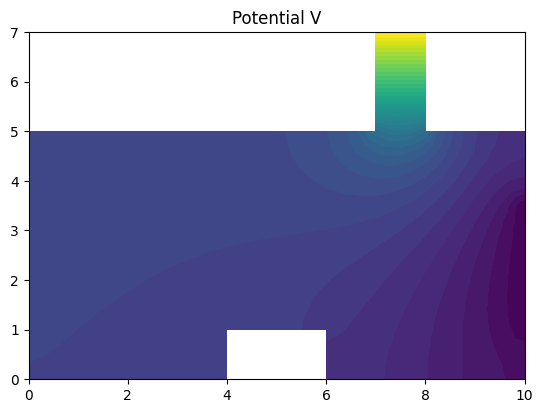

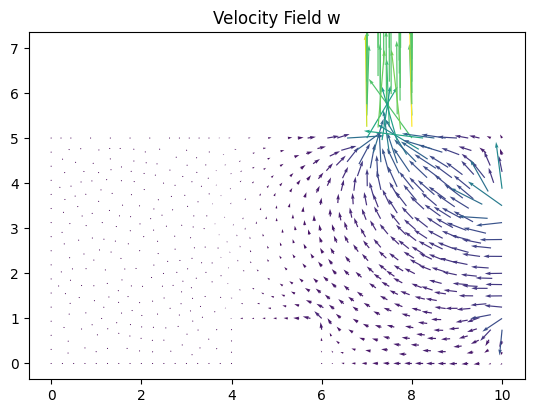

In [15]:
# Define boundary conditions for potential flow
V_in_value = Constant(-1.0)  # Example inlet potential
V_out_value = Constant(0.0)  # Example outlet potential

# Define boundaries
class InletWindow(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], 10) and between(x[1], (1, 3.5)))

class OutletBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 7)

inlet = InletWindow()
outlet = OutletBoundary()

boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
inlet.mark(boundary_markers, 1)
outlet.mark(boundary_markers, 2)

do = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

# Define boundary conditions
bc_inlet = DirichletBC(V, V_in_value, inlet)
bc_outlet = DirichletBC(V, V_out_value, outlet)

bcs = [bc_inlet, bc_outlet]

# Define variational problem for potential flow
V_potential = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(V_potential), grad(v)) * dx
L = Constant(0) * v * dx

# Solve the potential flow problem
V_solution = Function(V)
solve(a == L, V_solution, bcs)

# Compute the fluid velocity w = grad(V)
w = project(grad(V_solution), VectorFunctionSpace(mesh, 'P', 1))

# Plot the solution
import matplotlib.pyplot as plt

plt.figure()
plot(V_solution, title="Potential V")
plt.figure()
plot(w, title="Velocity Field w")
plt.show()

# Save solution to file
file = File("potential.pvd")
file << V_solution
file = File("velocity.pvd")
file << w


Time step 0: norm of difference = 1322.3068618350026


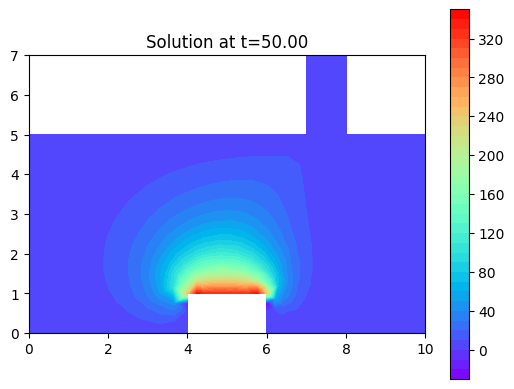

Time step 1: norm of difference = 344.68004466952016


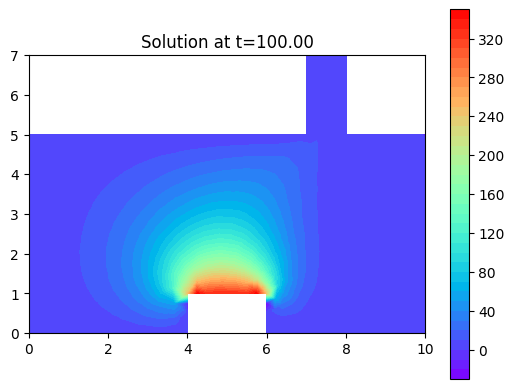

Time step 2: norm of difference = 182.87927907171726


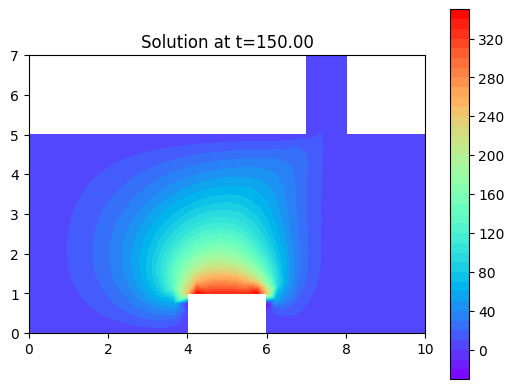

Time step 3: norm of difference = 103.75005840940133


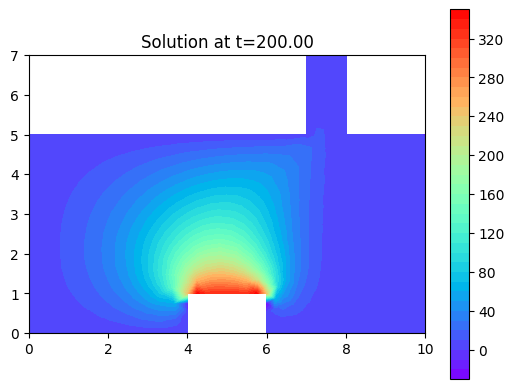

Time step 4: norm of difference = 59.86391091617749


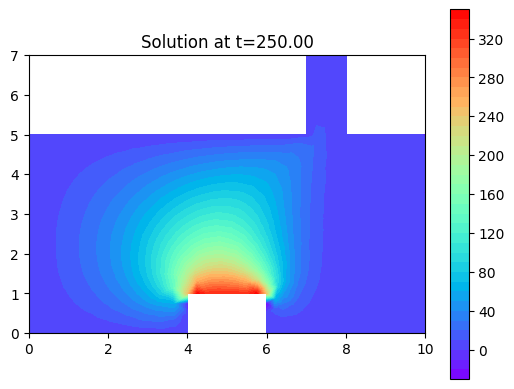

Time step 5: norm of difference = 34.858191570782004


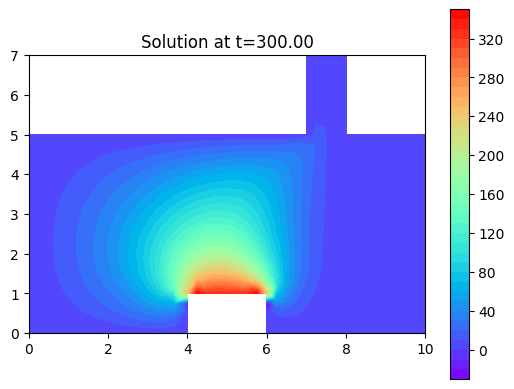

Time step 6: norm of difference = 20.428472436573905


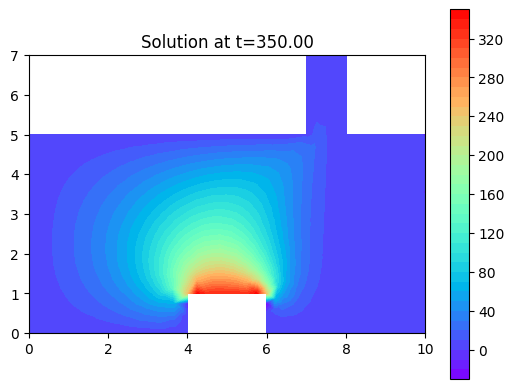

Time step 7: norm of difference = 12.025341450974578


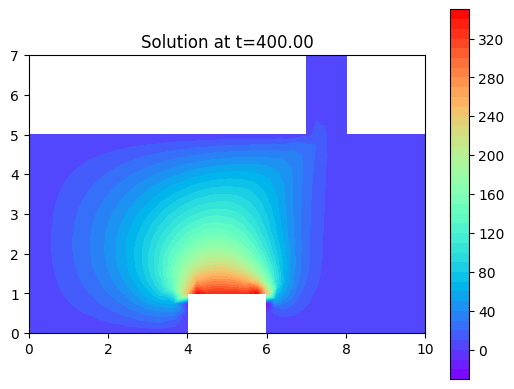

Time step 8: norm of difference = 7.099493998553627


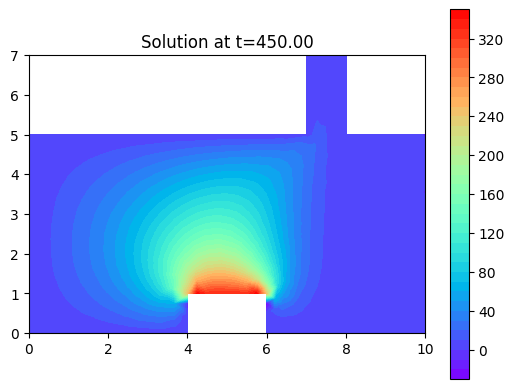

Time step 9: norm of difference = 4.1991788228216596


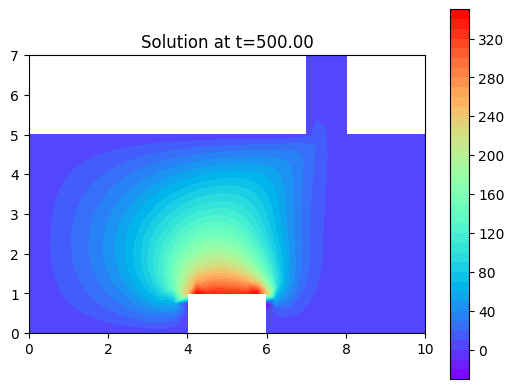

Time step 10: norm of difference = 2.4866144745545395


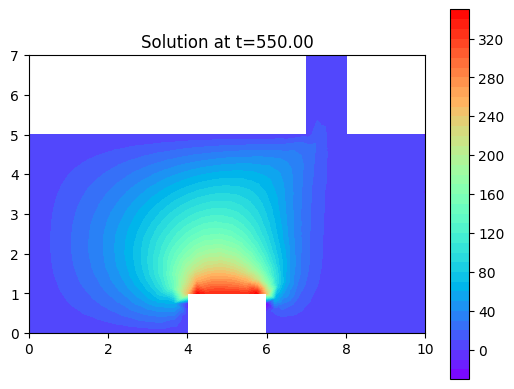

Time step 11: norm of difference = 1.4735735345283196


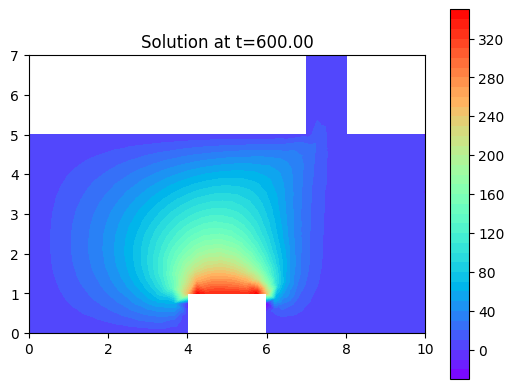

Time step 12: norm of difference = 0.8736518383528148


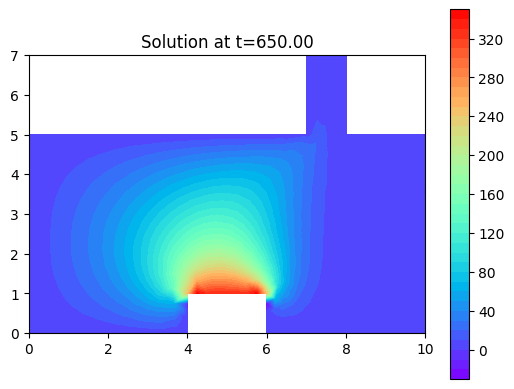

Time step 13: norm of difference = 0.5181272820696158


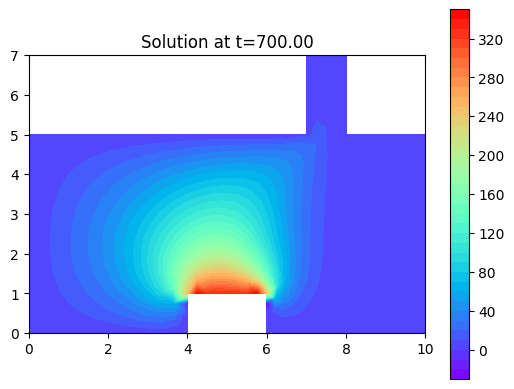

Time step 14: norm of difference = 0.3073414908044458


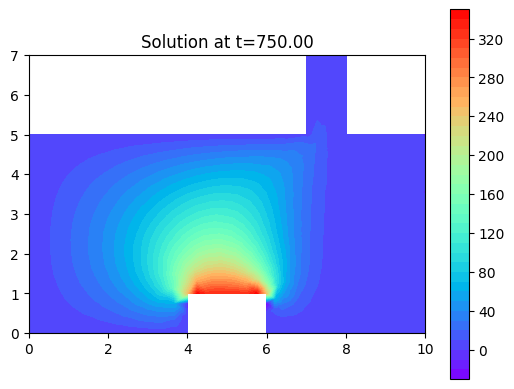

Time step 15: norm of difference = 0.18233252219817755


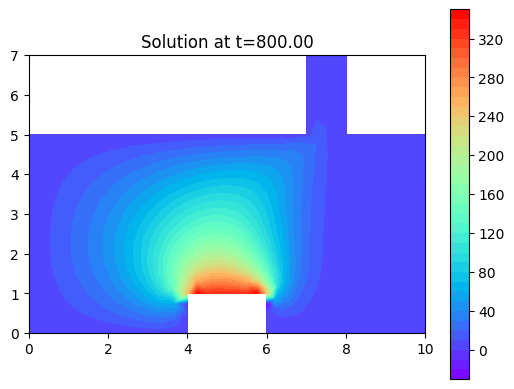

Time step 16: norm of difference = 0.10817997579136311


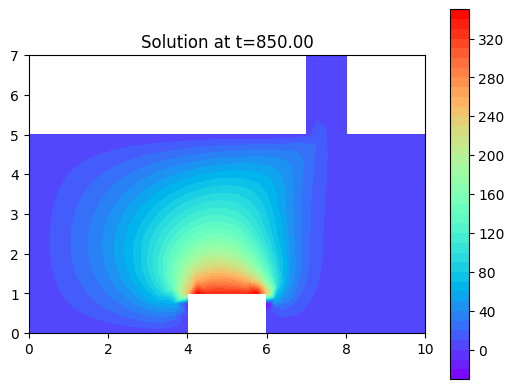

Time step 17: norm of difference = 0.06418850292411464


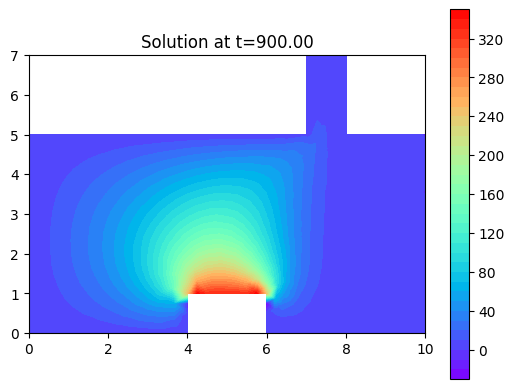

Time step 18: norm of difference = 0.03808790126334841


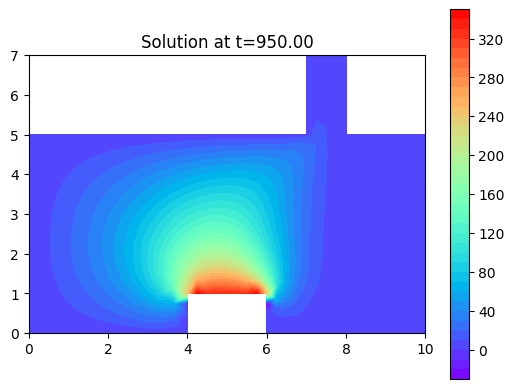

Time step 19: norm of difference = 0.022601155667846033


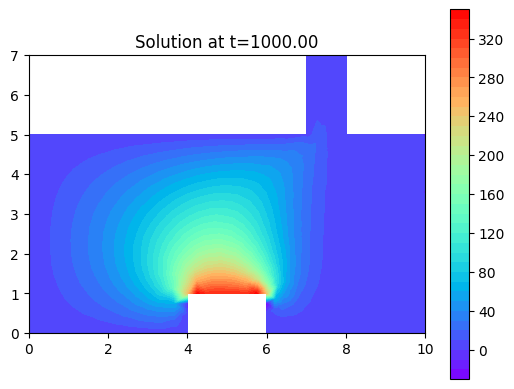

Time step 20: norm of difference = 0.013411709707798597


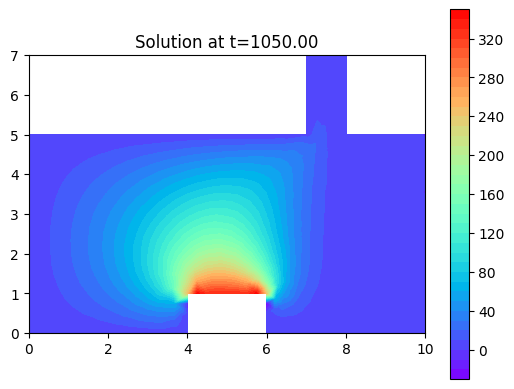

Time step 21: norm of difference = 0.007958748436095975


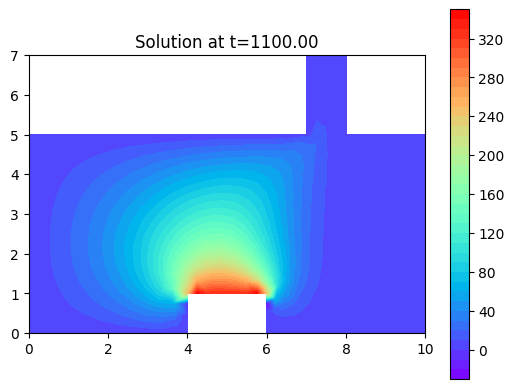

Time step 22: norm of difference = 0.004722919897676363


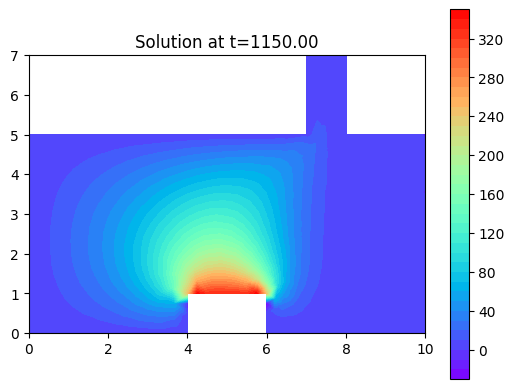

Time step 23: norm of difference = 0.0028027227647325747


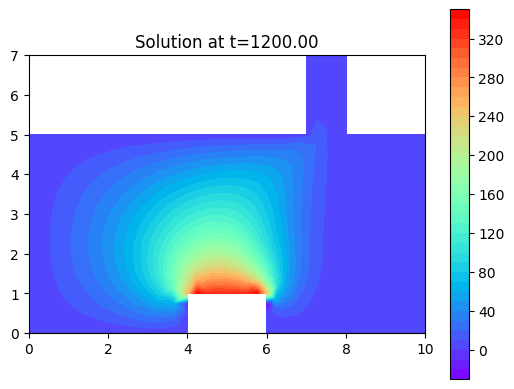

Time step 24: norm of difference = 0.0016632305081928248


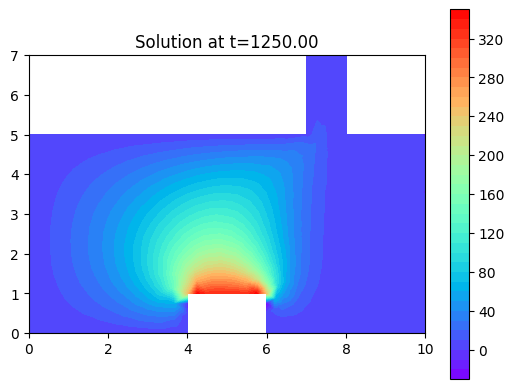

Time step 25: norm of difference = 0.0009870218019001544


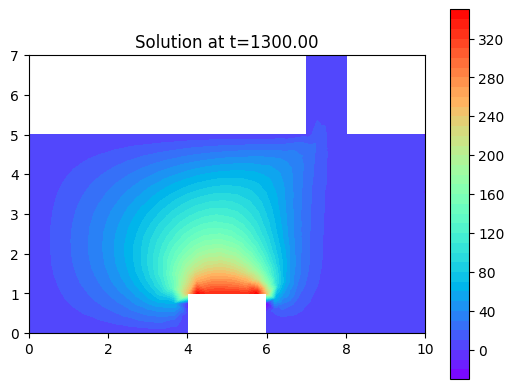

Time step 26: norm of difference = 0.0005857368036745441


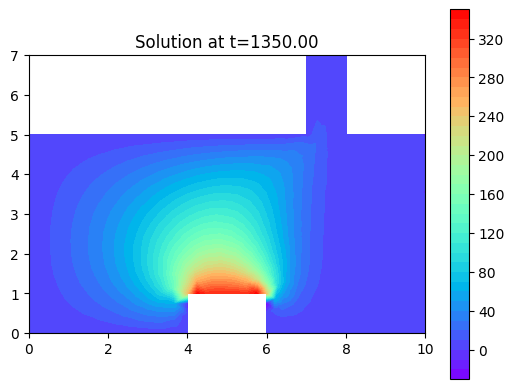

Time step 27: norm of difference = 0.0003475996669857051


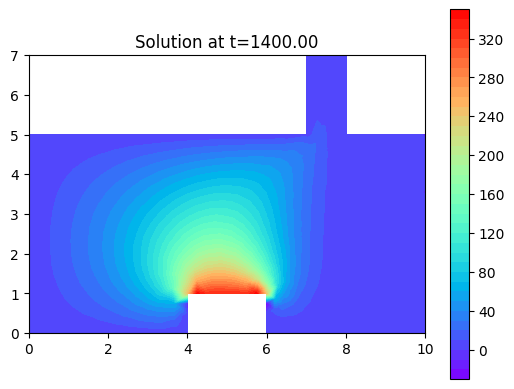

Time step 28: norm of difference = 0.0002062799303838841


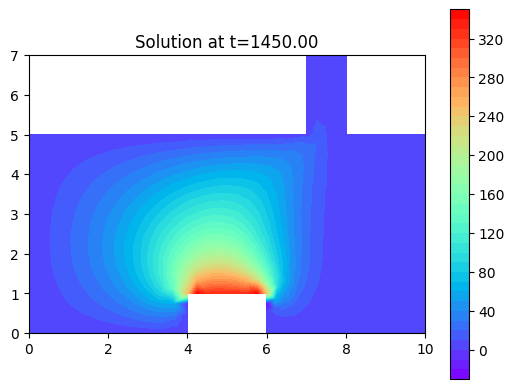

Time step 29: norm of difference = 0.00012241515220665718


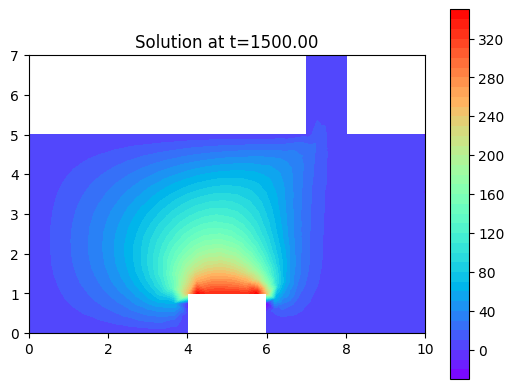

Time step 30: norm of difference = 7.26463501028306e-05


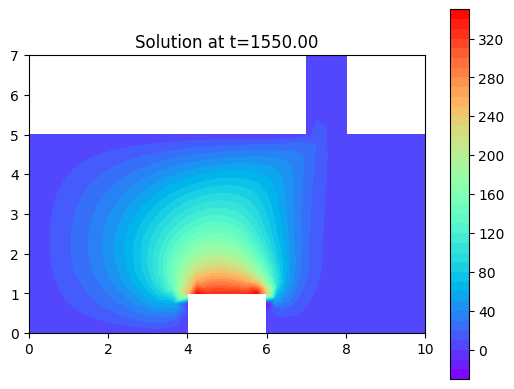

Time step 31: norm of difference = 4.311145989667683e-05


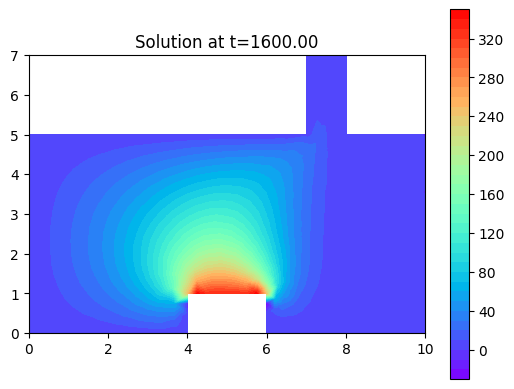

Time step 32: norm of difference = 2.5584203040646726e-05


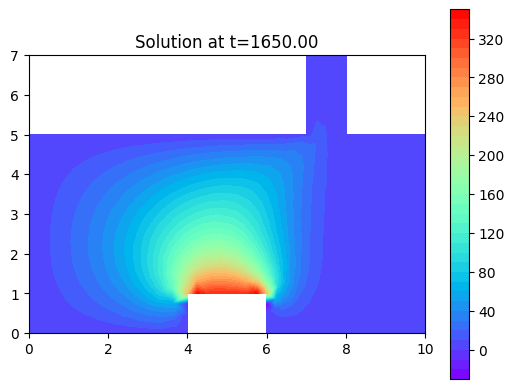

Time step 33: norm of difference = 1.5182777089383904e-05


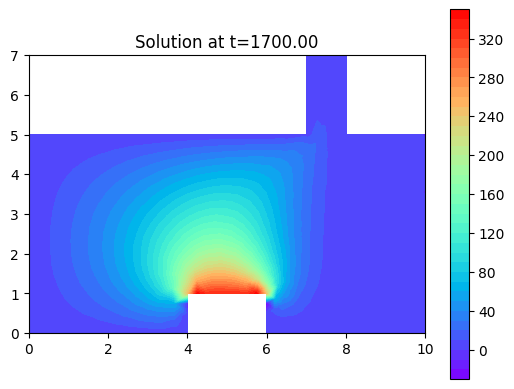

Time step 34: norm of difference = 9.010121974087111e-06


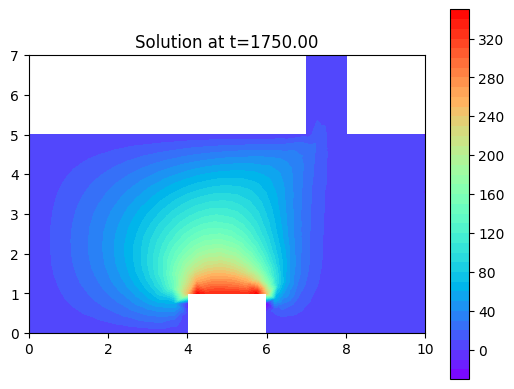

Time step 35: norm of difference = 5.347000423686389e-06


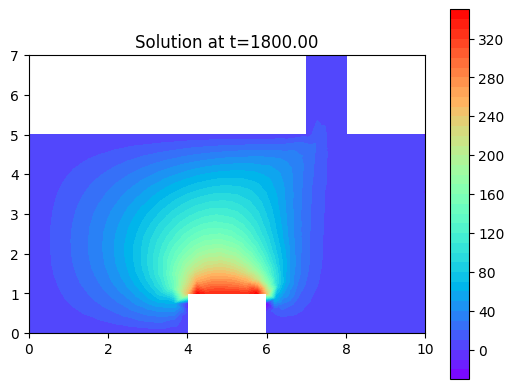

Time step 36: norm of difference = 3.173144136381652e-06


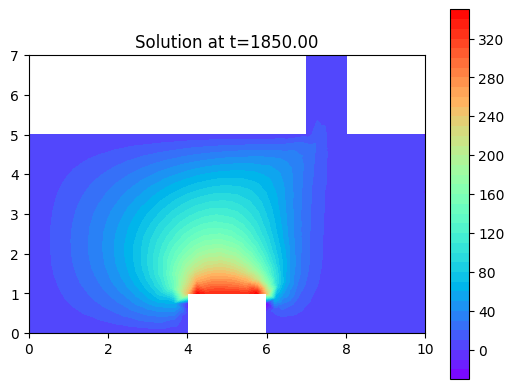

Time step 37: norm of difference = 1.8830828971355714e-06


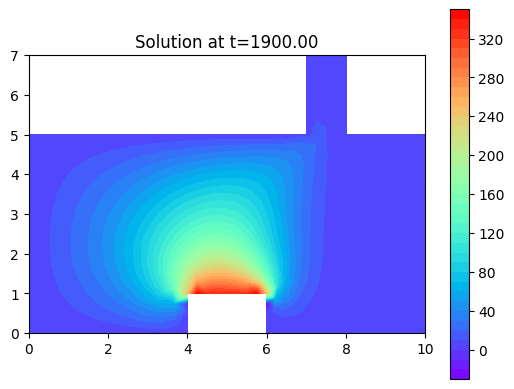

Time step 38: norm of difference = 1.117503928539665e-06


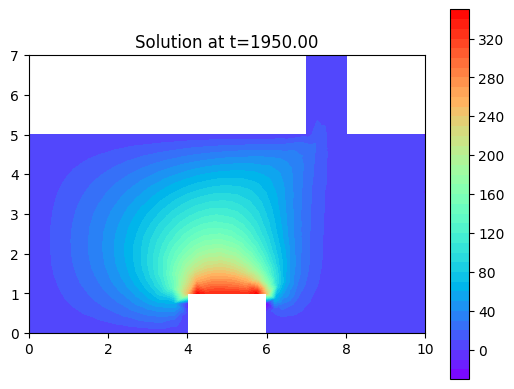

Time step 39: norm of difference = 6.631760256734542e-07
Convergence achieved at time step 39, t = 2000
Time-stepping loop finished


In [16]:
######################################
# Initial solution ("first guess") u0
# u0 = solution of a semi-linearized BVP
######################################
# Case mu constant diffusivity. Non-linear term : non-linear flux
#mu0_diri = mu( interpolate(u_diri_exp_1,V) )

# Set tolerance
tolerance = 1e-6

# Define initial condition u(x, 0) = 3
u_n = Function(V)
u_n.assign(Constant(3.0))

# Define constants
dt = 50
T = 10000
num_steps = int(T / dt)

# Define variational problem for time-stepping
u = TrialFunction(V)
v = TestFunction(V)

# Time-stepping loop
t = 0
for n in range(num_steps):
    t += dt
    
    # Update u_ref if needed, here it is constant
    a = (
        (u/dt)*v*dx + 
        mu0 * inner(grad(u), grad(v)) * dx  + 
        inner(w, grad(u)) * v * dx + # Introduce convective transfers
        c * (u_ref**(q-1) * u) * v * ds(6) + 
        wall_thick*u*v*ds(1) +
        roof_thick*u*v*ds(2) +
        chimney_thick*u*v*ds(3) +
        floor_thick*u*v*ds(4) +
        window_thick*u*v*ds(5) +
        wall_thick*u*v*ds(7)
    )
    L = (u_n/dt)*v*dx + fp*v*dx + c * (u_ref**q) * v * ds(6)
    
    u_new = Function(V)
    solve(a == L, u_new)

    # Check for convergence
    diff = u_new.vector() - u_n.vector()
    norm_diff = norm(diff, 'L2')
    
    print(f"Time step {n}: norm of difference = {norm_diff}")
    
    if norm_diff < tolerance:
        print(f"Convergence achieved at time step {n}, t = {t}")
        break
        
    # Update previous solution
    u_n.assign(u_new)
    
    # Plot or save the solution for visualization every few steps
    if n % 1 == 0 or n == num_steps - 1:
        plt.figure()
        p = plot(u_new, title=f'Solution at t={t:.2f}')
        p.set_cmap("rainbow")
        plt.colorbar(p)
        plt.show(block=False)

print("Time-stepping loop finished")

### Heat Equation Source Term

Given the heat equation in the form:
$$ \frac{\partial u}{\partial t} - \Delta u = f $$

Substituting the exact solution $ u_e(x_1, x_2) $:
$$ u_e(x_1, x_2) = \cos(\omega_1 x_1) \sin(\omega_2 x_2) $$

The Laplacian of \( u_e \) is:
$$ \Delta u_e = \frac{\partial^2 u_e}{\partial x_1^2} + \frac{\partial^2 u_e}{\partial x_2^2} $$

Calculating the second derivatives:
$$ \frac{\partial^2 u_e}{\partial x_1^2} = -\omega_1^2 \cos(\omega_1 x_1) \sin(\omega_2 x_2) $$
$$ \frac{\partial^2 u_e}{\partial x_2^2} = -\omega_2^2 \cos(\omega_1 x_1) \sin(\omega_2 x_2) $$

Thus:
$$ \Delta u_e = -\omega_1^2 \cos(\omega_1 x_1) \sin(\omega_2 x_2) - \omega_2^2 \cos(\omega_1 x_1) \sin(\omega_2 x_2) $$
$$ \Delta u_e = -(\omega_1^2 + \omega_2^2) \cos(\omega_1 x_1) \sin(\omega_2 x_2) $$

So, the source term $ f $ in the heat equation is:
$$ f = \frac{\partial u_e}{\partial t} - \Delta u_e $$
Since the solution $ u_e $ is steady-state (i.e., $\frac{\partial u_e}{\partial t} = 0$):
$$ f = -\Delta u_e = (\omega_1^2 + \omega_2^2) \cos(\omega_1 x_1) \sin(\omega_2 x_2) $$


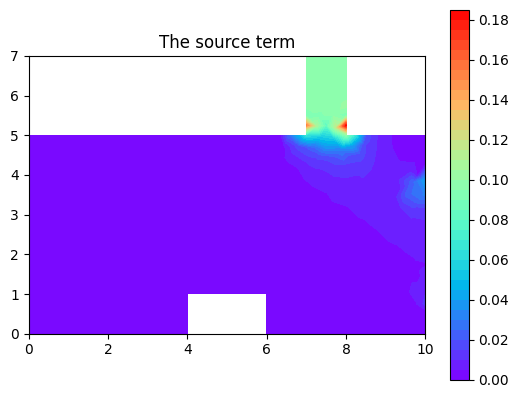

In [22]:
# Extract components w_0 and w_1
w_0 = w.sub(0, deepcopy=True)
w_1 = w.sub(1, deepcopy=True)

# Source term expression
fp_exp2 = Expression('pow(w0, 2) + pow(w1, 2)', w0=w_0, w1=w_1, element = V.ufl_element())

##############
# Source term
# fp_exp = Expression(('(w_0**2+w_1**2)cos(w_0*x[0])sin(w_1*x[1]'), element = V.ufl_element())
# fp_exp = Expression(('0.'), element = V.ufl_element())
fp2 = interpolate(fp_exp,V)
# Plot
p = plot(fp,title='The source term')
p.set_cmap("rainbow"); plt.colorbar(p); plt.show()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Time step 0: norm of difference = 1322.3889710617157


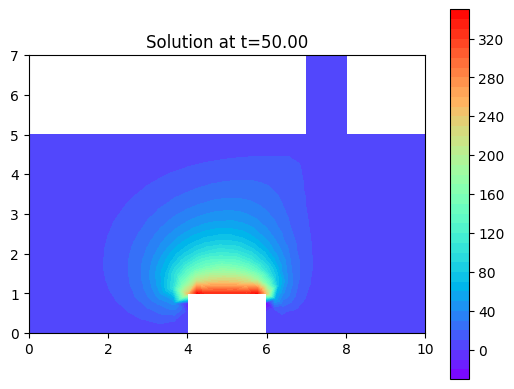

Time step 1: norm of difference = 344.8479158872966


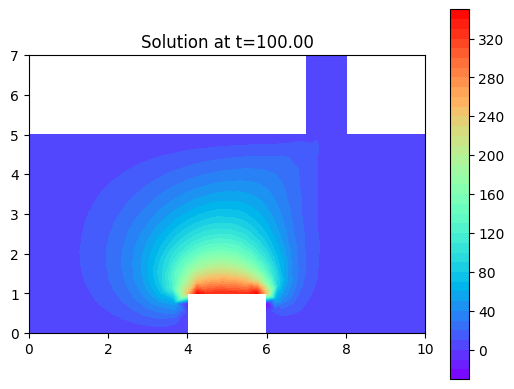

Time step 2: norm of difference = 182.98827328301522


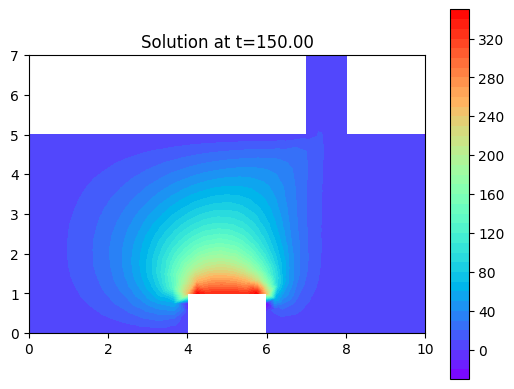

Time step 3: norm of difference = 103.8109693802618


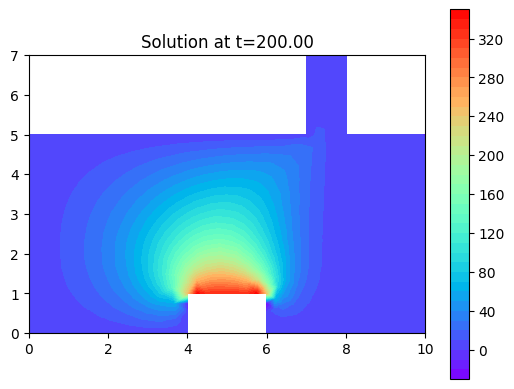

Time step 4: norm of difference = 59.89725511657726


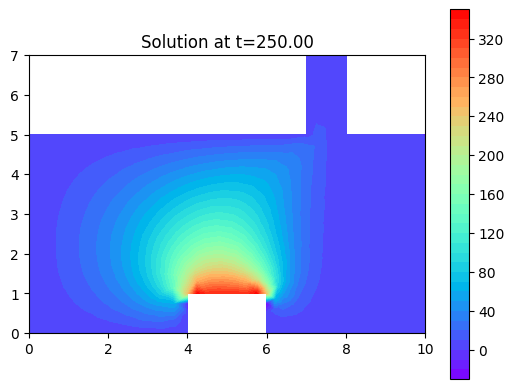

Time step 5: norm of difference = 34.87668592267086


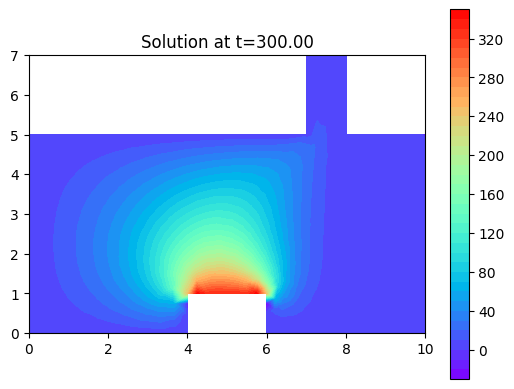

Time step 6: norm of difference = 20.438926370830266


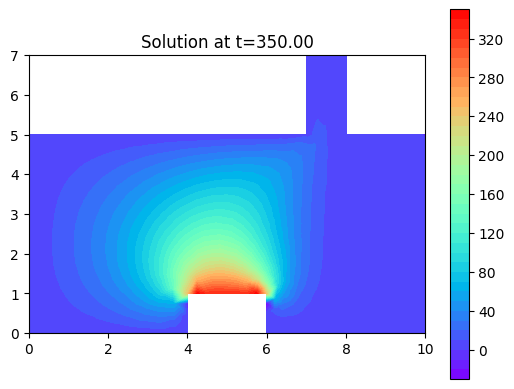

Time step 7: norm of difference = 12.031346158659506


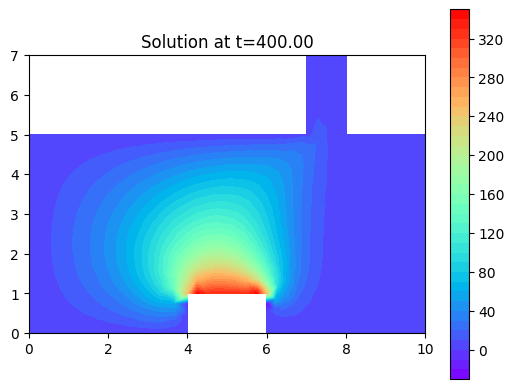

Time step 8: norm of difference = 7.102982949854583


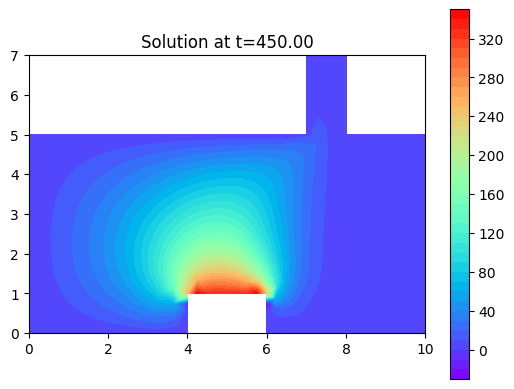

Time step 9: norm of difference = 4.201221501444591


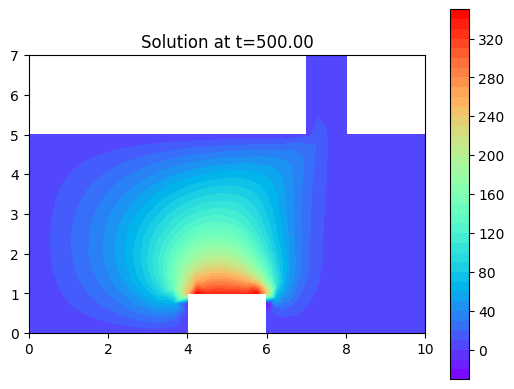

Time step 10: norm of difference = 2.4878162128611225


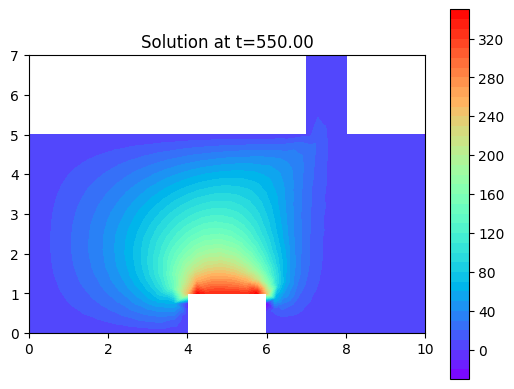

Time step 11: norm of difference = 1.4742826931844106


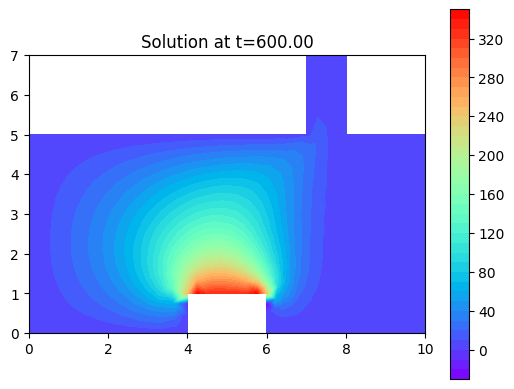

Time step 12: norm of difference = 0.874071124559791


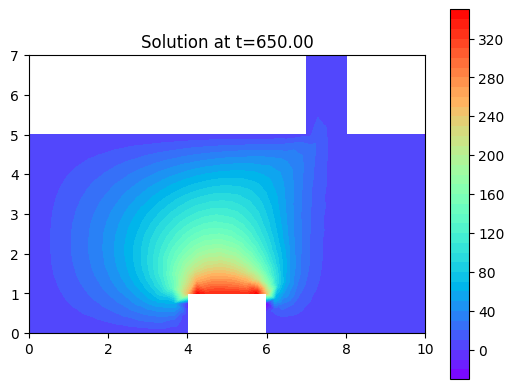

Time step 13: norm of difference = 0.5183754859311488


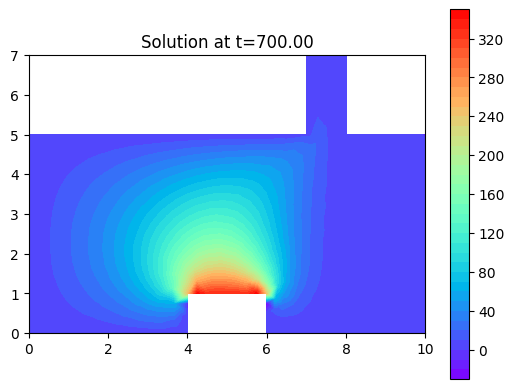

Time step 14: norm of difference = 0.30748853571776597


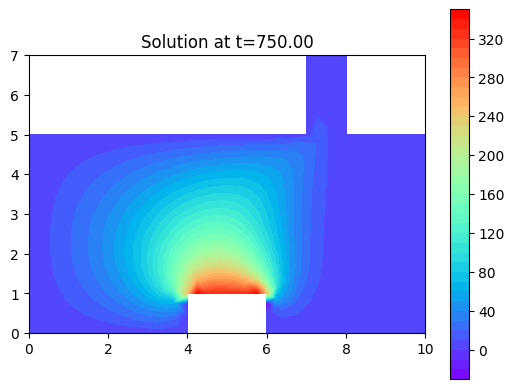

Time step 15: norm of difference = 0.18241968235772194


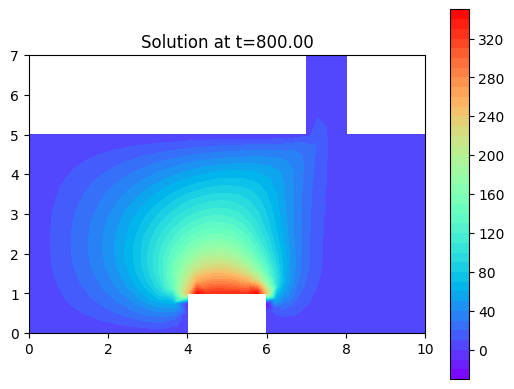

Time step 16: norm of difference = 0.10823165767131408


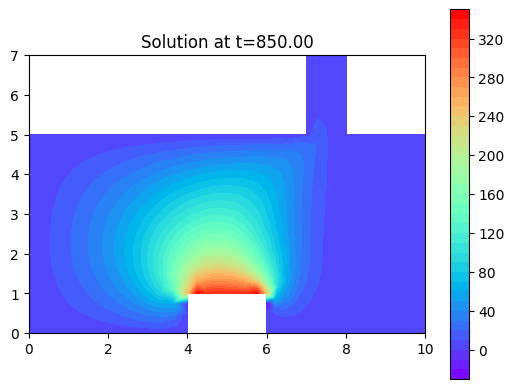

Time step 17: norm of difference = 0.06421915520518755


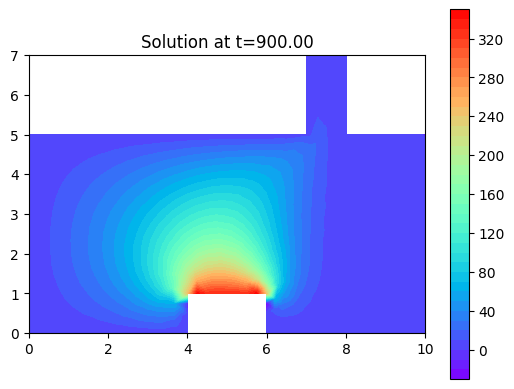

Time step 18: norm of difference = 0.03810608402022954


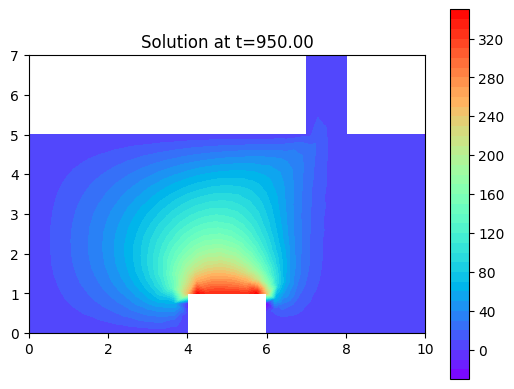

Time step 19: norm of difference = 0.02261194284153023


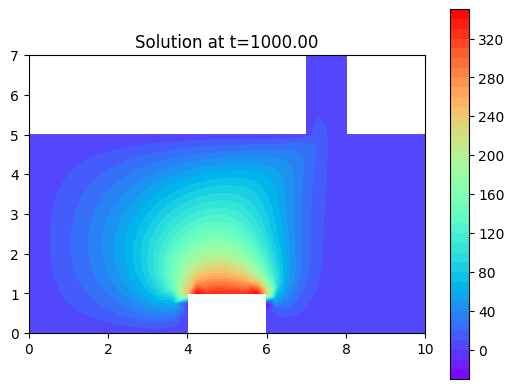

Time step 20: norm of difference = 0.013418109883360983


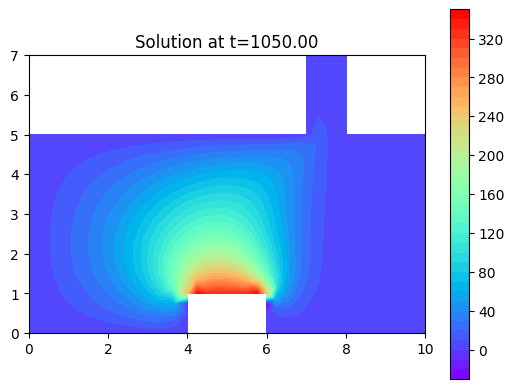

Time step 21: norm of difference = 0.00796254597519341


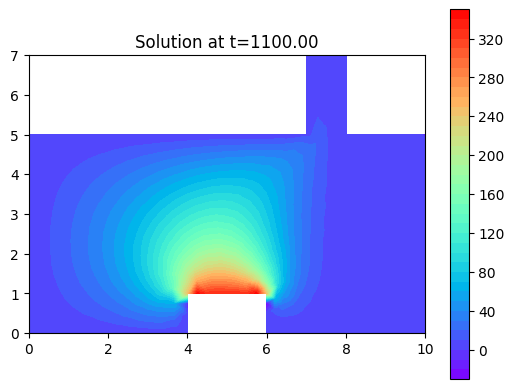

Time step 22: norm of difference = 0.004725173261221985


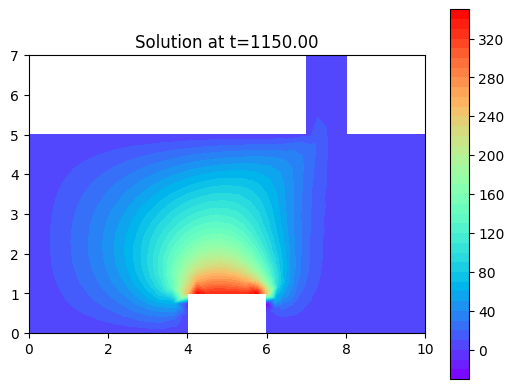

Time step 23: norm of difference = 0.002804059896145242


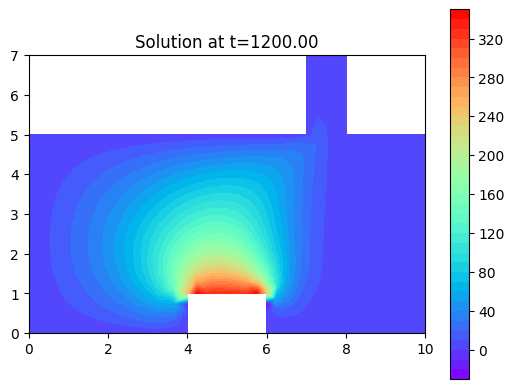

Time step 24: norm of difference = 0.0016640239713484792


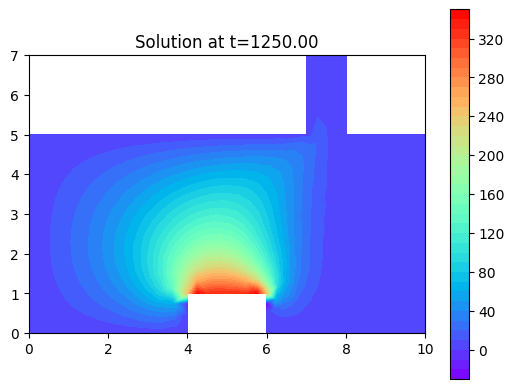

Time step 25: norm of difference = 0.000987492656217428


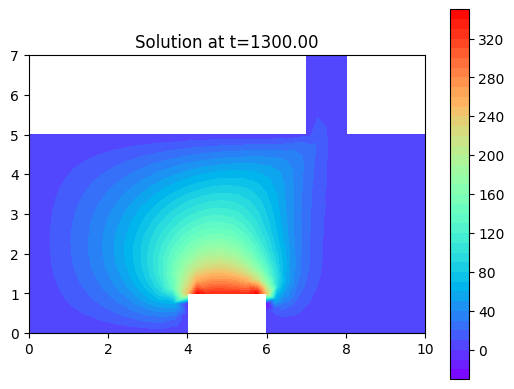

Time step 26: norm of difference = 0.0005860162199057818


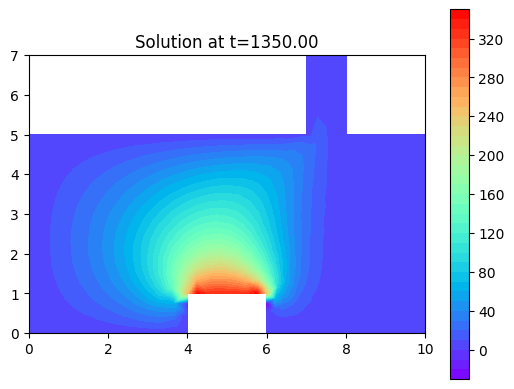

Time step 27: norm of difference = 0.00034776548128510534


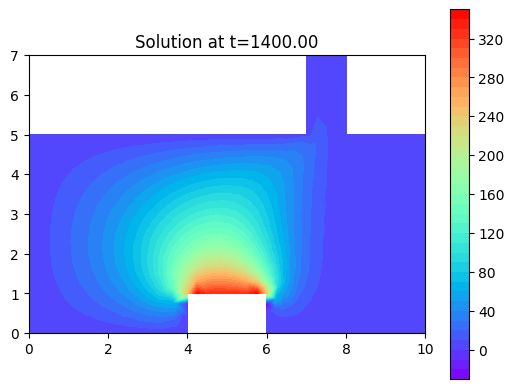

Time step 28: norm of difference = 0.00020637832997902922


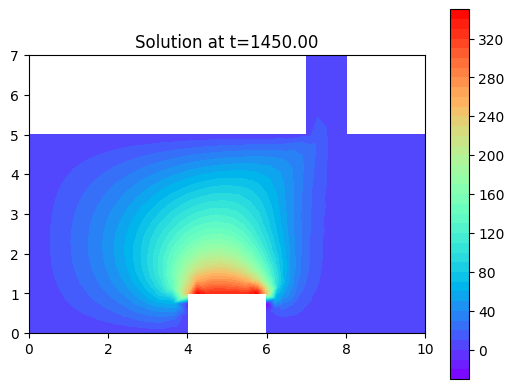

Time step 29: norm of difference = 0.0001224735459931498


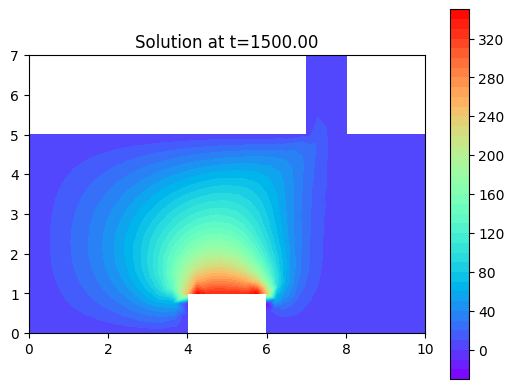

Time step 30: norm of difference = 7.268100304002176e-05


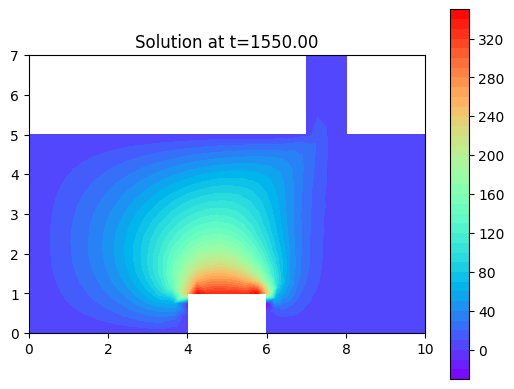

Time step 31: norm of difference = 4.313202463124182e-05


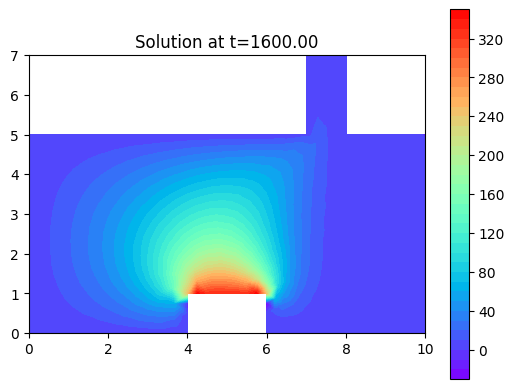

Time step 32: norm of difference = 2.559640683854252e-05


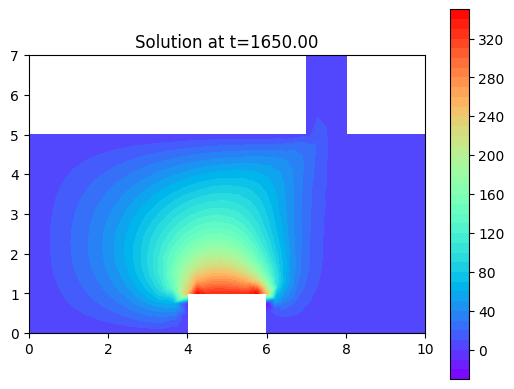

Time step 33: norm of difference = 1.5190019459474029e-05


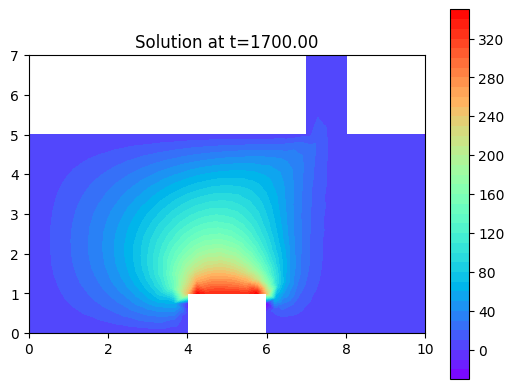

Time step 34: norm of difference = 9.014419621687345e-06


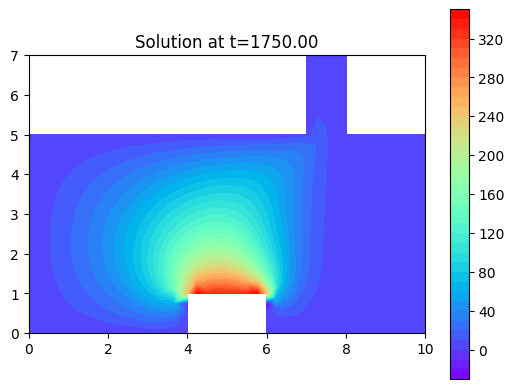

Time step 35: norm of difference = 5.34955063684411e-06


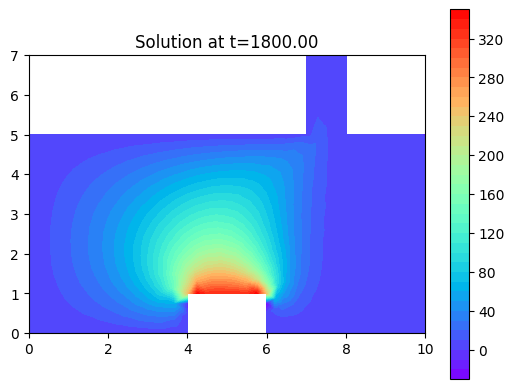

Time step 36: norm of difference = 3.174657893371056e-06


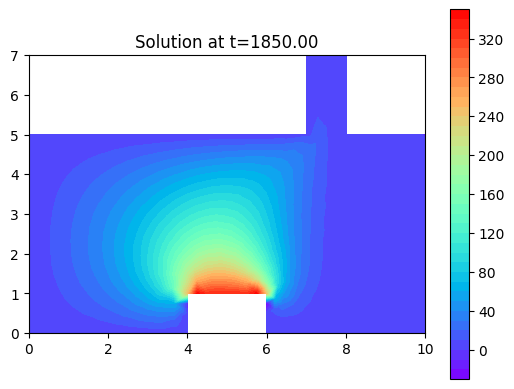

Time step 37: norm of difference = 1.883981287477576e-06


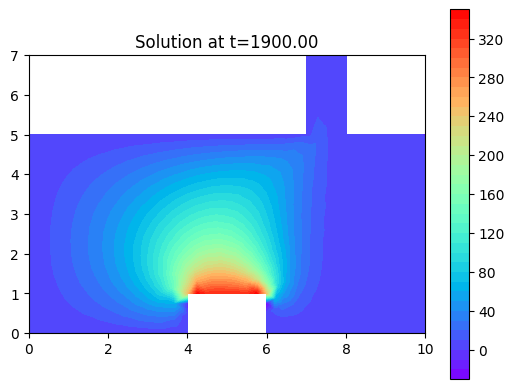

Time step 38: norm of difference = 1.1180371935568529e-06


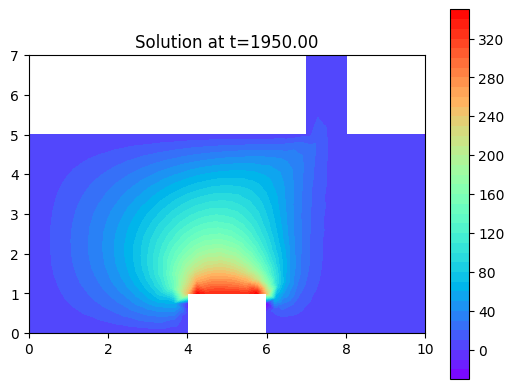

Time step 39: norm of difference = 6.634924689506868e-07
Convergence achieved at time step 39, t = 2000
Time-stepping loop finished


In [23]:
######################################
# Initial solution ("first guess") u0
# u0 = solution of a semi-linearized BVP
######################################
# Case mu constant diffusivity. Non-linear term : non-linear flux
#mu0_diri = mu( interpolate(u_diri_exp_1,V) )

# Set tolerance
tolerance = 1e-6

# Define initial condition u(x, 0) = 3
u_n = Function(V)
u_n.assign(Constant(3.0))

# Define constants
dt = 50
T = 10000
num_steps = int(T / dt)

# Define variational problem for time-stepping
u = TrialFunction(V)
v = TestFunction(V)

# Time-stepping loop
t = 0
for n in range(num_steps):
    t += dt
    
    # Update u_ref if needed, here it is constant
    a = (
        (u/dt)*v*dx + 
        mu0 * inner(grad(u), grad(v)) * dx  + 
        inner(w, grad(u)) * v * dx + # Introduce convective transfers
        c * (u_ref**(q-1) * u) * v * ds(6) + 
        wall_thick*u*v*ds(1) +
        roof_thick*u*v*ds(2) +
        chimney_thick*u*v*ds(3) +
        floor_thick*u*v*ds(4) +
        window_thick*u*v*ds(5) +
        wall_thick*u*v*ds(7)
    )
    L = (u_n/dt)*v*dx + fp2*v*dx + c * (u_ref**q) * v * ds(6) #Using new source term
    
    u_new = Function(V)
    solve(a == L, u_new)

    # Check for convergence
    diff = u_new.vector() - u_n.vector()
    norm_diff = norm(diff, 'L2')
    
    print(f"Time step {n}: norm of difference = {norm_diff}")
    
    if norm_diff < tolerance:
        print(f"Convergence achieved at time step {n}, t = {t}")
        break
        
    # Update previous solution
    u_n.assign(u_new)
    
    # Plot or save the solution for visualization every few steps
    if n % 1 == 0 or n == num_steps - 1:
        plt.figure()
        p = plot(u_new, title=f'Solution at t={t:.2f}')
        p.set_cmap("rainbow")
        plt.colorbar(p)
        plt.show(block=False)

print("Time-stepping loop finished")